In [28]:
from ResolvedGalaxy import ResolvedGalaxy,MockResolvedGalaxy
import time
import matplotlib.colors as cm
# Default matplotlib color cycle
from matplotlib import rcParams
from astropy.table import Table
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import h5py
import glob
import copy
from astropy.io import fits
from itertools import cycle
from astropy.cosmology import Planck18 as cosmo
from scipy import signal
from tqdm import tqdm
from synthesizer.emission_models import IncidentEmission
from synthesizer.filters import FilterCollection as Filters
from synthesizer.grid import Grid
from synthesizer.kernel_functions import Kernel
from synthesizer.particle.galaxy import Galaxy
from unyt import Hz, erg, Mpc, kpc, Msun, yr, s, arcsecond, nJy, K, Angstrom, unyt_array, um, uJy
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from synthesizer.emission_models.attenuation.igm import Inoue14, Madau96
from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Greybody

In [29]:
cosmo  = FlatLambdaCDM(H0=70, Om0=0.300)

# Define the grid
# Here we are using the Stellar Population Synthesis grid called BPASS (version 2.2.1),
# which includes binary stars, same as the one used to generate all the FLARES photometry
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c17.03"
grid_dir = "/nvme/scratch/work/tharvey/synthesizer/grids/"
grid = Grid(grid_name, grid_dir=grid_dir)

path = '/nvme/scratch/work/tharvey/synthesizer/flares_flags_balmer_project.hdf5'


In [30]:
# Reading in the required galaxy particle data
# These are the requested galaxies
# You could also put them as nexted dictionaries!

redshift_index = 3 # redshift index
galaxy_index = 0 # 

tags = {'010_z005p000':['00', '00', '01', '10', '18'], '008_z007p000':['00', '02', '09'], '007_z008p000':['21', '17'], '005_z010p000':['15']}
ids = {'010_z005p000':[12, 96, 1424, 1006, 233], '008_z007p000':[6, 46, 298], '007_z008p000':[111, 16], '005_z010p000':[99]}


# Lets read them from the provided hdf5 file
# It should be the file called flares_flags_balmer_project.hdf5
# Lets start with the first one
def load_galaxy(redshift_code, galaxy_index, path = path):
    #tags = ['010_z005p000', '008_z007p000', '007_z008p000', '005_z010p000']
    #regions = [['00', '00', '01', '10', '18'], ['00', '02', '09'], ['21', '17'], ['15']]
    #ids = [[12, 96, 1424, 1006, 233], [6, 46, 298], [111, 16], [99]]

    regions = {'010_z005p000':['00', '00', '01', '10', '18'], '008_z007p000':['00', '02', '09'], '007_z008p000':['21', '17'], '005_z010p000':['15']}
    ids = {'010_z005p000':[12, 96, 1424, 1006, 233], '008_z007p000':[6, 46, 298], '007_z008p000':[111, 16], '005_z010p000':[99]}

    id = ids[redshift_code][galaxy_index] - 1
    tag = redshift_code
    region = regions[redshift_code][galaxy_index]

    #tag = tags[redshift_index]
    #region = regions[redshift_index][galaxy_index]
    #id = ids[redshift_index][galaxy_index] - 1

    print (tag, region, id)

    zed = float(tag[5:].replace("p", "."))

    with h5py.File(path,'r') as hf:  #opening the hdf5 file
        # coordinates of the stellar particles 
        coordinates = np.array(hf[f"{tag}/{region}/{id}"].get('coordinates'), dtype=np.float64) * Mpc
        # initial masses of the stellar particles
        initial_masses = np.array(hf[f"{tag}/{region}/{id}"].get('initial_masses'), dtype=np.float64) * Msun
        # current masses of the stellar particles, mass change due to mass loss as stars age
        current_masses = np.array(hf[f"{tag}/{region}/{id}"].get('initial_masses'), dtype=np.float64) * Msun
        # ages of stars in log10, which is in units of years
        log10ages = np.array(hf[f"{tag}/{region}/{id}"].get('log10ages'), dtype=np.float64)
        # metallicities of the stars in log10
        log10metallicities = np.array(hf[f"{tag}/{region}/{id}"].get('log10metallicities'), dtype=np.float64)
        # optical depth in the V-band, it is the same prescription as shown in Vijayan+21, which
        # includes the V-band dust optical depth due to the diffuse ISM dust and birth cloud dust
        tau_v = np.array(hf[f"{tag}/{region}/{id}"].get('tau_v'), dtype=np.float64)
        # the smoothing lengths of star particles
        smoothing_lengths = np.array(hf[f"{tag}/{region}/{id}"].get('smoothing_lengths'), dtype=np.float64) * Mpc


        gal = Galaxy(redshift=zed)
        gal.load_stars(
            initial_masses=initial_masses,
            ages=10**log10ages * yr,
            metallicities=10**log10metallicities,
            coordinates=coordinates,
            current_masses=current_masses,
            smoothing_lengths=smoothing_lengths,
            centre=np.zeros(3)*Mpc
        )

    gal.tau_v = tau_v

    return gal

gal = load_galaxy('005_z010p000', galaxy_index)


005_z010p000 15 98


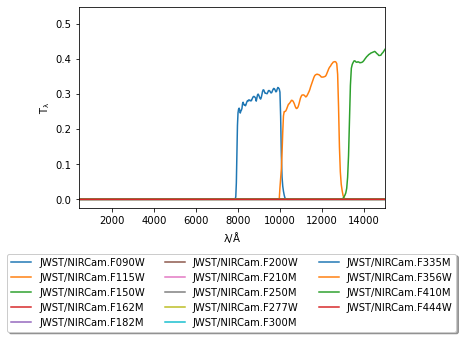

In [31]:
filter_codes = [
    "JWST/NIRCam.F090W",
    "JWST/NIRCam.F115W",
    "JWST/NIRCam.F150W",
    "JWST/NIRCam.F162M",
    "JWST/NIRCam.F182M",
    "JWST/NIRCam.F200W",
    "JWST/NIRCam.F210M",
    "JWST/NIRCam.F250M",
    "JWST/NIRCam.F277W",
    "JWST/NIRCam.F300M",
    "JWST/NIRCam.F335M",
    "JWST/NIRCam.F356W",
    "JWST/NIRCam.F410M",
    "JWST/NIRCam.F444W",
]

#"HST/ACS_WFC.F435W",
#"HST/ACS_WFC.F606W",
#"HST/ACS_WFC.F814W",
#"HST/ACS_WFC.F775W",
#"HST/ACS_WFC.F850LP",

filters = Filters(filter_codes, new_lam=grid.lam)

fig, ax = filters.plot_transmission_curves()
plt.xlim(400, 15000)
plt.show()


In [46]:
print(depths)

{'JWST/NIRCam.F090W': unyt_quantity(0.00434548, 'μJy'), 'JWST/NIRCam.F115W': unyt_quantity(0.0040624, 'μJy'), 'JWST/NIRCam.F150W': unyt_quantity(0.00325616, 'μJy'), 'JWST/NIRCam.F162M': unyt_quantity(0.00400232, 'μJy'), 'JWST/NIRCam.F182M': unyt_quantity(0.0028527, 'μJy'), 'JWST/NIRCam.F200W': unyt_quantity(0.00328011, 'μJy'), 'JWST/NIRCam.F210M': unyt_quantity(0.00341409, 'μJy'), 'JWST/NIRCam.F250M': unyt_quantity(0.00423652, 'μJy'), 'JWST/NIRCam.F277W': unyt_quantity(0.00257239, 'μJy'), 'JWST/NIRCam.F300M': unyt_quantity(0.00334496, 'μJy'), 'JWST/NIRCam.F335M': unyt_quantity(0.00307922, 'μJy'), 'JWST/NIRCam.F356W': unyt_quantity(0.00252738, 'μJy'), 'JWST/NIRCam.F410M': unyt_quantity(0.00443302, 'μJy'), 'JWST/NIRCam.F444W': unyt_quantity(0.00281372, 'μJy')}


005_z010p000 15 98


/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/nvme/scratch/work/tharvey/synthesizer/synthesizer/src/synthesizer/emission_models/attenuation/igm.py:382: RuntimeWarning: overflow encountered in exp
  transmission = np.exp(-tau)


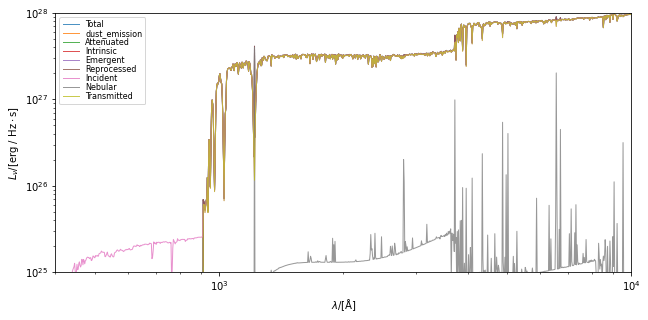

100%|██████████| 1000/1000 [00:25<00:00, 39.79it/s]
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Total good: 68.40714285714286%
[True, True, True, False, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, False, True, True, True, True, False, True, True, False, False, True, True, True, True, True, False, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, False, True, True, False, True, True, True, True, False, False, True, True, True, False, True, False, True, True, True, False, False, True, True, True, False, True, False, False, True, False, True, False, True, False, True, True, True, False, False, False, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, True, True, False, True, True, False, False, True, True, True, False, True, False, True, True, False, True, True, False, False, Tr

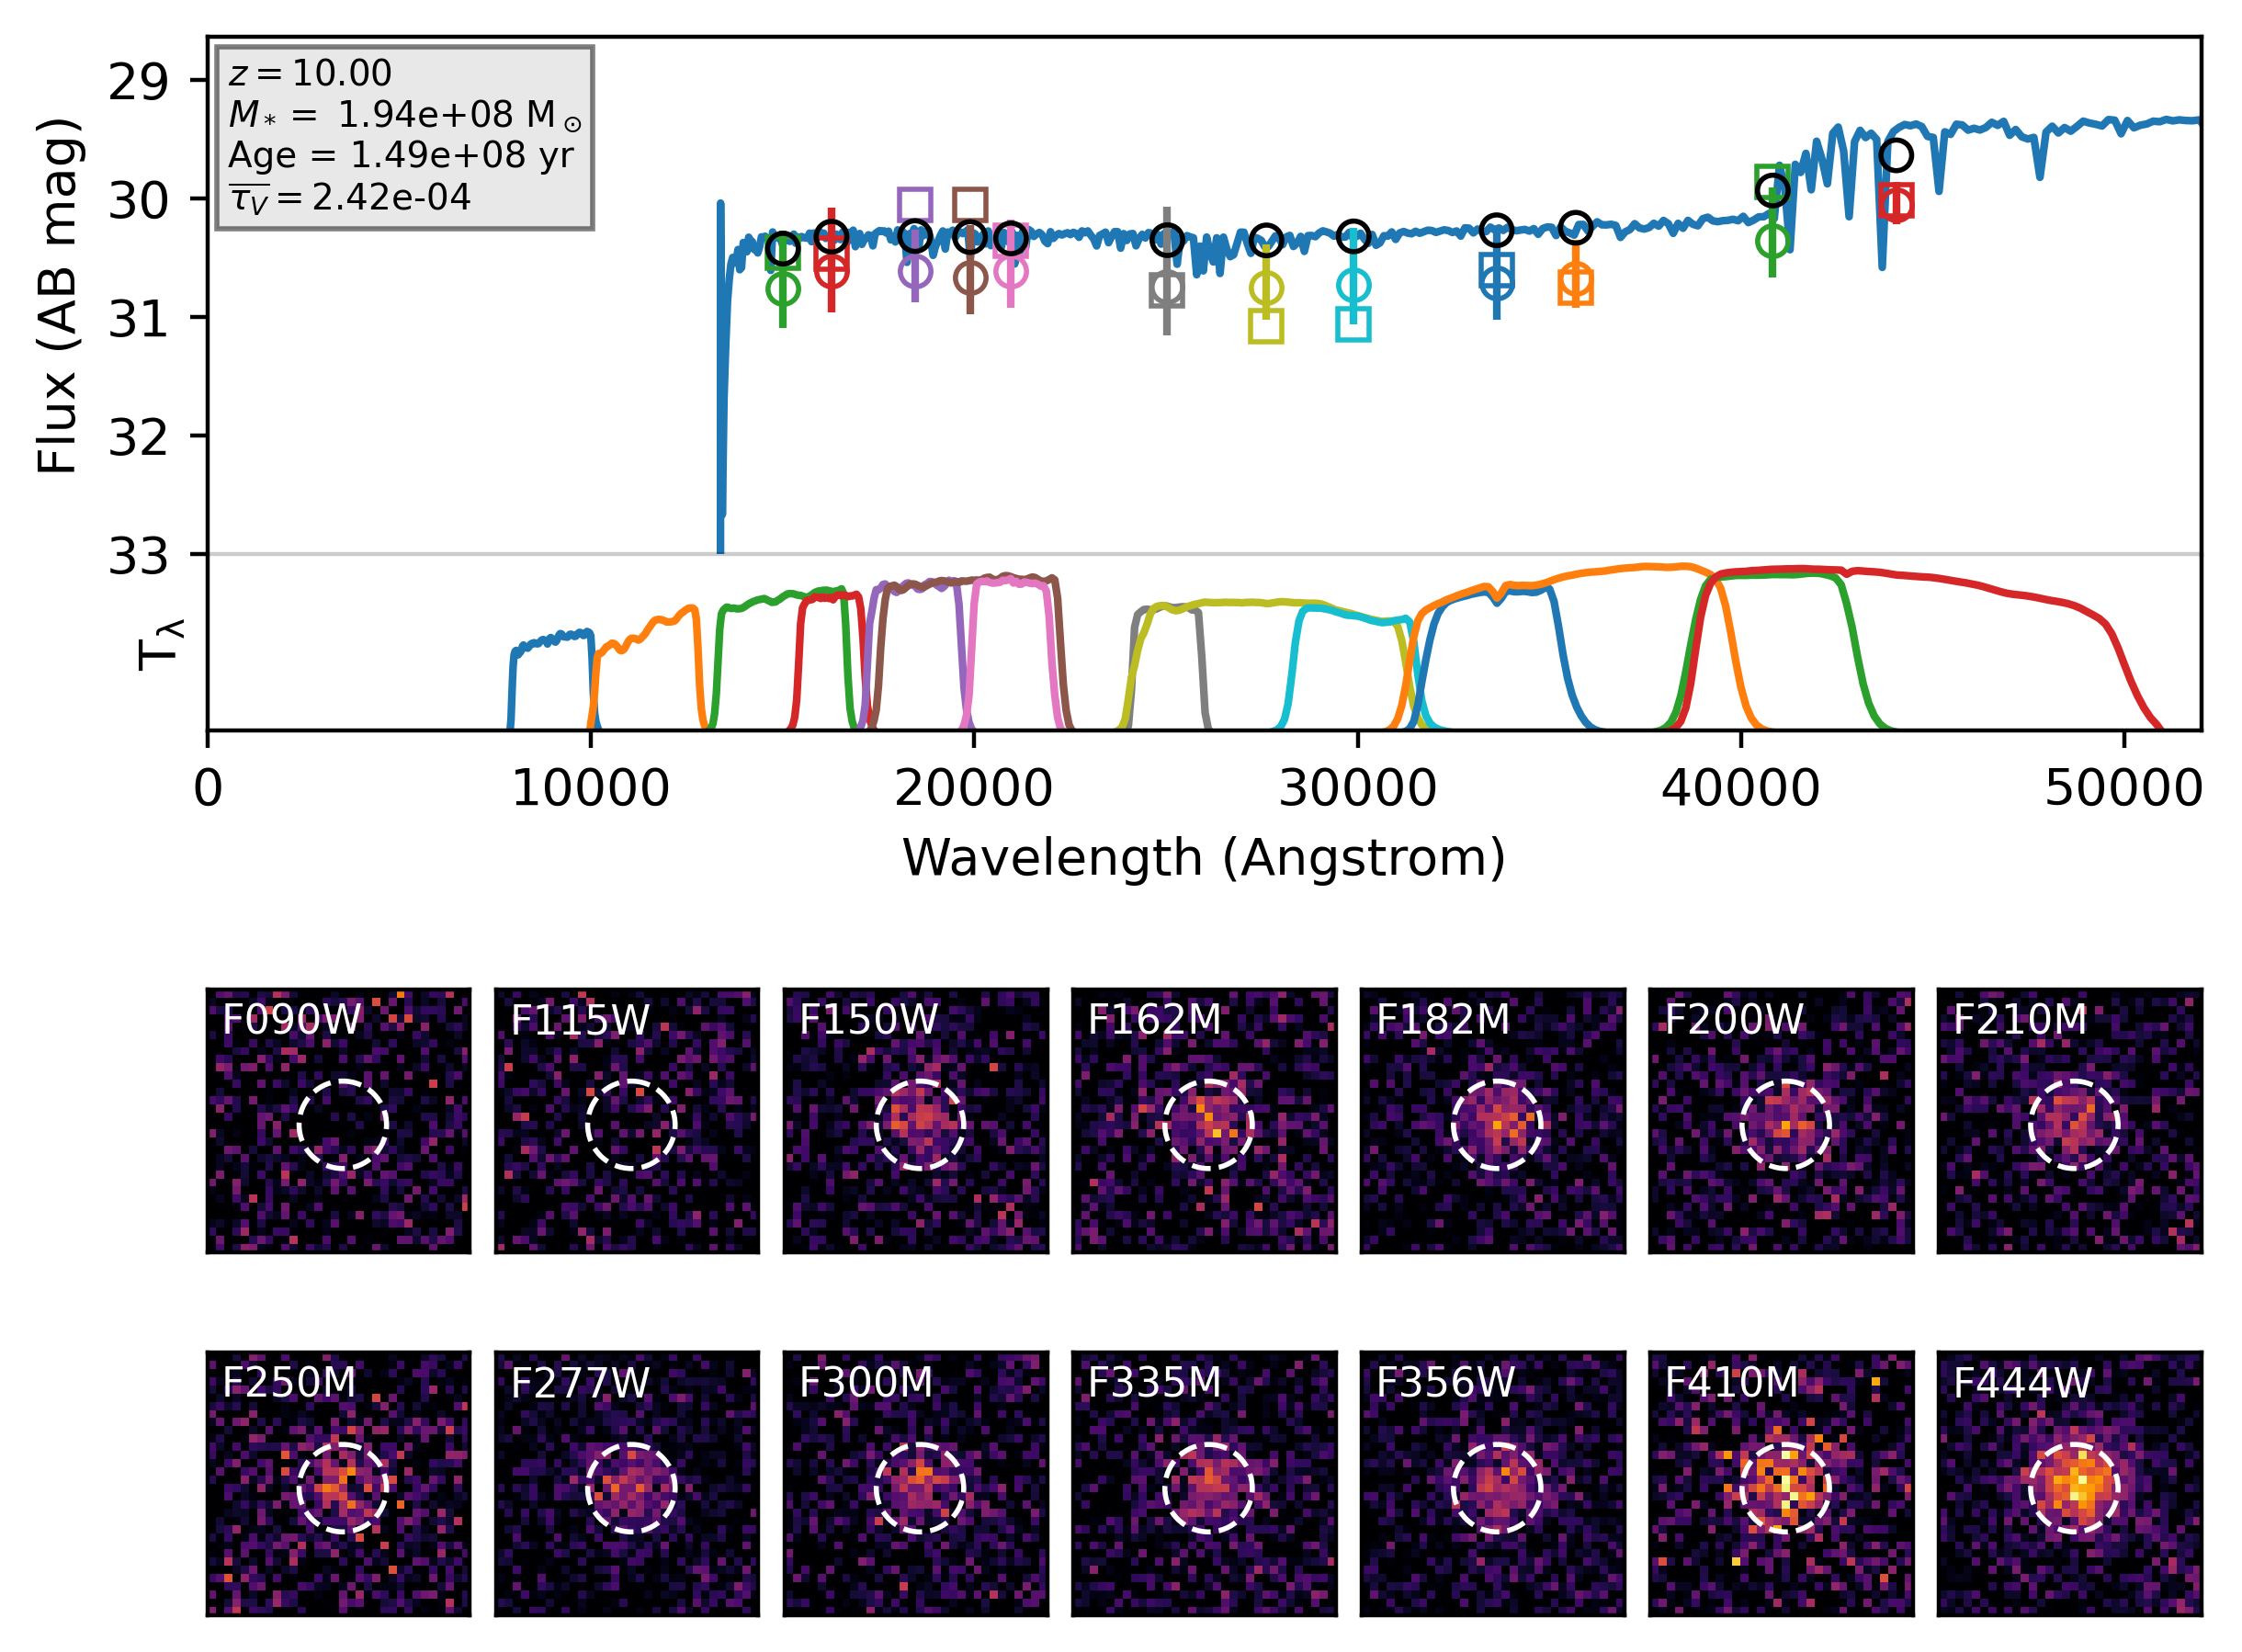

<Figure size 360x252 with 0 Axes>

In [57]:
def model_emission(galaxy, tau_v = None, plot = False):
    emission_model = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=PowerLaw(slope=-0.7),
    dust_emission=Greybody(30 * K, 1.2))

    gal.stars.get_particle_spectra(emission_model)
    models = gal.stars.particle_spectra.keys()
    for model in models:
        # Generate spectra for each particle for each model component
        gal.stars.particle_spectra[model].get_fnu(cosmo, gal.redshift, igm=Inoue14)
        # Need this for making luminosity images only
        gal.stars.particle_spectra[model].get_photo_lnu(filters)
        

    # Combines the spectra of all the particles
    gal.stars.integrate_particle_spectra()

    if plot:
        gal.stars.plot_spectra(show = True, xlimits = unyt_array([400, 10000], units = Angstrom), ylimits = [1e25, 1e30], figsize = (10, 6))

    gal.stars.get_particle_photo_fnu(filters)

    gal.stars.get_photo_fnu(filters)
    #gal.stars.get_photo_lnu(filters) # unneeded apparently

    return gal


def plot_particle_sed(gal, spec_type = 'total', filters = filters, fig = None, imgs = None, aperture_size_kpc = None, five_sigma_depths = None):
    if fig is None:
        fig, ax = plt.subplots(nrows=2, ncols=1, height_ratios=[3, 1], dpi = 400)
        ax, ax_filt = ax

    else:
        gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
        ax = fig.add_subplot(gs[0])
        ax_filt = fig.add_subplot(gs[1])

        
    if spec_type == 'all':
        spec_type = gal.stars.spectra.keys()
    elif type(spec_type) == str:
        spec_type = [spec_type]
    for s in spec_type:
        sed = gal.stars.spectra[s]
        phot = gal.stars.photo_fnu[s]
        ax.plot(sed.obslam, -2.5* np.log10(sed.fnu) + 31.40, label = s)
        ax.scatter(filters.pivot_lams.ndarray_view(), -2.5*np.log10(phot.photo_fnu.to(nJy)) + 31.40, marker = 'o', color = 'black', facecolors='none', zorder = 10)

    # default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = colors*5
    markers = ['s', 'o', 'v', 'D', 'P', 'X', 'H', 'd', 'p', 'x', 'h', '^', '<', '>', 'v']
    if imgs is not None:
        if type(imgs) != list:
            imgs = [imgs]
        for img_pos, img in enumerate(imgs):
            for pos, key in enumerate(img.keys()):
                unit = img[key].units
                if unit != nJy:
                    img[key].arr = (img[key].arr * unit).to(nJy).value
                    img[key].units = nJy

                if aperture_size_kpc is not None:
                    center = img[key].arr.shape[0] / 2
                    signal = img[key].get_signal_in_aperture(aperture_radius = aperture_size_kpc, aperture_cent = (center, center))
                    ax.plot(filters.pivot_lams[pos], -2.5*np.log10(signal) + 31.40, marker = markers[img_pos], color = 'none', markeredgecolor = colors[pos])

                if five_sigma_depths is not None and img_pos == 1:
                    flux = signal
                    flux_err = five_sigma_depths[key]/5
                    mag_err_list = [[np.abs(2.5*np.log10(flux/(flux-flux_err)))], [np.abs(2.5 * np.log10(1+flux_err/flux))]]
                    #print(mag_err_list)
                    ax.errorbar(filters.pivot_lams[pos], -2.5*np.log10(flux) + 31.40, yerr = mag_err_list, marker = 'none', color = colors[pos])



    ax.set_xlim(0, 52000)
    ax_filt.set_xlim(0, 52000)
    ax.set_xticks([])
    
    vals = -2.5*np.log10(phot.photo_fnu.to(nJy)) + 31.40

    ymin = np.min(vals) - 1.0
    ymax = np.max(vals) + 1.0
    if ymax > 33:
        ymax = 33

    ax.set_ylim(ymax, ymin)

    

    filters.plot_transmission_curves(ax = ax_filt)
    ax_filt.set_xlabel("Wavelength (Angstrom)")
    ax.set_ylabel("Flux (AB mag)")
    # Remove upper and right axes
    ax_filt.spines['top'].set_visible(False)
    ax.spines['bottom'].set_alpha(0.2)

    fig.subplots_adjust(hspace=0.01)
    # No legends
    ax_filt.legend().remove()
    ax_filt.set_ylim(0.01, None)
    ax_filt.set_yticklabels('')
    ax_filt.set_yticks([])


    text = '\n'.join((f'$z = {gal.redshift:.2f}$',
                        f'$M_* = $ {gal.stellar_mass.value:.2e} ${gal.stellar_mass.units.latex_repr}$',
                        f'Age = {gal.stellar_mass_weighted_age:.2e}',
                        rf'$\overline{{\tau_V}} = ${gal.tau_v.mean():.2e}'
    ))
    props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)
    ax.text(0.01, 0.96, text, transform=ax.transAxes, fontsize=7,
            verticalalignment='top', bbox=props)

    if len(spec_type) > 1:
        ax.legend(frameon = False)
    return fig

#fig = plot_particle_sed(gal, spec_type = 'total', filters = filters)

def make_images(galaxy, cutout_size = 100, resolution = 0.03 * arcsecond, 
                sph_kernel = Kernel(),  img_type = "smoothed",
                spectra_type = 'total', psfs = None):
    
    # Calculate size and resolution of the cutouts
    re = 1
    d_A = cosmo.angular_diameter_distance(gal.redshift)
    pix_scal = u.pixel_scale(resolution.to(arcsecond).value*u.arcsec/u.pixel)
    re_as = (re * u.pixel).to(u.arcsec, pix_scal)
    re_kpc = (re_as * d_A).to(u.kpc, u.dimensionless_angles())

    resolution = re_kpc.value * kpc
    width = cutout_size * resolution

    # Get the SPH kernel

    kernel_data = sph_kernel.get_kernel()

    # Get the image
    imgs = gal.get_images_flux(
        resolution,
        fov=width,
        img_type=img_type,
        stellar_photometry=spectra_type,
        blackhole_photometry=None,
        kernel=kernel_data,
        kernel_threshold=1,
    )

    if psfs is not None:
        # Apply the PSFs
        psf_imgs = imgs.apply_psfs(psfs)
    else:
        psf_imgs = imgs

    return psf_imgs

def apply_noise(images, radius = 0.16 * u.arcsec,
                    depth_file = '/raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/JOF_depths.ecsv',
                    return_depths = False):

    d_A = cosmo.angular_diameter_distance(gal.redshift)
    radius_kpc = (radius * d_A).to(u.kpc, u.dimensionless_angles())
    radius_kpc = radius_kpc.value * kpc

    snrs = {f: 5 for f in images.keys()}  

    table = Table.read(depth_file, format='ascii.ecsv')
    # Select 'all' region column
    table = table[table['region'] == 'all']
    #band_depths:
    bands = [i.split('.')[1] for i in filters.filter_codes]
    band_depths = {}
    for band in bands:
        row = table[table['band'] == band]
        data = row['median_depth']
        band_depths[band] = data * u.ABmag
    wavs = {f:np.squeeze(filters.pivot_lams[pos].value) for pos, f in enumerate(bands)}
    # Convert to uJy from AB mag
    depths = {img_key:band_depths[f].to(u.uJy, equivalencies=u.spectral_density(wavs)).value * uJy for f, img_key in zip(bands, images.keys())}
    depths = {k: v[0] for k, v in depths.items()}

    #print(depths)

    noise_app_imgs = images.apply_noise_from_snrs(snrs=snrs, depths=depths, aperture_radius=radius_kpc, sqrt = False, trunc = None)

    if return_depths:
        return noise_app_imgs, depths
    
    return noise_app_imgs

def apply_psf(images,  psfs_dir = '/nvme/scratch/work/tharvey/PSFs/JOF/'):
    psfs = {}
    files = glob.glob(f'{psfs_dir}/*_psf.fits')
    bands = [i.split('.')[1] for i in filters.filter_codes] 
    for band, code in zip(bands, filter_codes):
        psf_file = [f for f in files if band in f][0]
        psf = fits.open(psf_file)[0].data
        psfs[code] = psf
    
    # Apply the PSFs
    psf_imgs = images.apply_psfs(psfs)
    
    return psf_imgs

def plot_images(imgs, filters = filters, fig = None, max_on_row = 7, aper_radius = 0.16 * u.arcsec):
    if fig is None:
        fig = plt.figure(figsize=(20, 10), dpi = 400, facecolor='w')
    n = len(imgs)
    n_rows = int(np.ceil(n / max_on_row))
    n_cols = min(n, max_on_row)
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.1, hspace=0.1)

    vmax = 0
    for img in imgs.values():
        up = np.percentile(img.arr, 99.9)
        if up > vmax:
            vmax = up
    # Convert vmax to nJy

    #Broken after this
    units = imgs[filters.filter_codes[0]].units
    vmax = vmax * units

    for i, (img, fcode) in enumerate(zip(imgs, filters.filter_codes)):
        ax = fig.add_subplot(gs[i])
        unit = img.units
        img_data = img.arr * unit

        ax.imshow(img_data.to(nJy), cmap='inferno', vmin = 0, vmax = vmax.to(nJy))
        #ax.set_title(fcode)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.05, 0.95, fcode.split('.')[1], color = 'white', transform=ax.transAxes, fontsize = 8, ha = 'left', va = 'top')
        #ax.set_title(filters[i].name)
        if aper_radius is not None:
            from matplotlib.patches import Circle
            center = img_data.shape[0] / 2
            pixel_scale = 0.03 * u.arcsecond
            ax.add_patch(Circle((center, center), aper_radius/pixel_scale, fill = False, edgecolor = 'white', linestyle = 'dashed'))
    return fig

def pretty_plot(gal, images, filters, spec_type, depths = None):

    # Create an info box
    fig = plt.Figure(figsize = (7, 5), dpi = 400, facecolor='w')
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
    sed_fig = fig.add_subfigure(gs[0])
    img_fig = fig.add_subfigure(gs[1])

    sed_fig = plot_particle_sed(gal, spec_type = spec_type, filters = filters, 
                                fig = sed_fig, imgs = images,
                                aperture_size_kpc = 0.6657108613771668 * kpc,
                                five_sigma_depths = depths)
    img_fig = plot_images(images[0], filters = filters, fig = img_fig)

    return fig

#for redshift_code in tags.keys():
#    for pos in range(len(tags[redshift_code])):
redshift_code = '005_z010p000' 
pos = 0

# '010_z005p000' - 5
# '008_z007p000' - 3
# '007_z008p000' - 2
# '005_z010p000' - 1

def flux_within_1sigma(noisy_img, psf_img, depth):
    good = []
    for key in noisy_imgs.keys():
        error = depth[key]/5
        center = noisy_img[key].arr.shape[0] / 2
        flux = noisy_img[key].get_signal_in_aperture(aperture_radius =  0.6657108613771668 * kpc, aperture_cent = (center, center)).to(uJy)
        flux_before = psf_img[key].get_signal_in_aperture(aperture_radius =  0.6657108613771668 * kpc, aperture_cent = (center, center)).to(uJy)
        #print(key, flux, flux_before, error)

        if flux_before - error < flux < flux_before + error:
            i = True

        else:
            i = False

        good.append(i)
        #print(key, i, -2.5*np.log10(flux.to(nJy).value) + 31.40, -2.5*np.log10(flux_before.to(nJy).value) + 31.40)
        
    return good
 

gal = load_galaxy(redshift_code, pos)
gal = model_emission(gal, tau_v = gal.tau_v)
imgs = make_images(gal, cutout_size = 32)
    
psf_imgs = apply_psf(imgs)

test_errors = False
if test_errors:
    total_good = []
    for i in tqdm(range(1000)):
        noisy_imgs, depths = apply_noise(psf_imgs, return_depths = True)
        good = flux_within_1sigma(noisy_imgs, psf_imgs, depths)
        total_good.extend(good)
    
    print(f'Total good: {100 * np.sum(total_good)/len(total_good)}%')


else:
    noisy_imgs, depths = apply_noise(psf_imgs, return_depths = True)


fig = pretty_plot(gal, [noisy_imgs, psf_imgs], filters, 'total', depths = depths)
fig.savefig(f'plots/simulated_galaxies/{redshift_code}_{pos}.png', bbox_inches = 'tight')
fig
###gal = model_emission(gal)

#imgs = make_images(gal)
#psf_imgs = apply_psf(imgs)

#noisy_imgs = apply_noise(psf_imgs)

#fig = pretty_plot(gal, noisy_imgs, filters, 'total')

#fig.savefig(f'plots/simulated_galaxies/{tag}_{region}_{id}.png', bbox_inches = 'tight')

In [33]:
fig = pretty_plot(gal, noisy_imgs, filters, 'total', depths = depths)
fig

/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


KeyError: 0

<Figure size 360x252 with 0 Axes>

In [ ]:
sssss

NameError: name 'sssss' is not defined

In [ ]:
a = 1/np.sqrt(noisy_imgs[filter_codes[-1]].weight_map) * uJy

err_array = noisy_imgs[filter_codes[-1]].noise_arr

print(np.std(err_array), a)


5.750051570999759e-05 μJy 5.9530243032413626e-05 μJy


In [67]:
radius = 0.16 * u.arcsec
d_A = cosmo.angular_diameter_distance(gal.redshift)
radius_kpc = (radius * d_A).to(u.kpc, u.dimensionless_angles())
radius_kpc = radius_kpc.value * kpc
print(radius_kpc)

depth_file = '/raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/JOF_depths.ecsv'
table = Table.read(depth_file, format='ascii.ecsv')
# Select 'all' region column
table = table[table['region'] == 'all']
#band_depths:
bands = [i.split('.')[1] for i in filters.filter_codes]
band_depths = {}
for band in bands:
    row = table[table['band'] == band]
    data = row['median_depth']
    band_depths[band] = data * u.ABmag
wavs = {f:np.squeeze(filters.pivot_lams[pos].value) for pos, f in enumerate(bands)}
# Convert to uJy from AB mag
depths = {img_key:band_depths[f].to(u.uJy, equivalencies=u.spectral_density(wavs)).value * uJy for f, img_key in zip(bands, imgs.keys())}
depths = {k: v[0] for k, v in depths.items()}


print('filter psf_flux noisy_flux 1_sigma_error(from depth)')
for key in noisy_imgs.keys():
    
    unit = noisy_imgs[key].units
    if unit != uJy:
        noisy_imgs[key].arr = (noisy_imgs[key].arr * unit).to(uJy).value
        noisy_imgs[key].units = uJy

    center = noisy_imgs[key].arr.shape[0] / 2
    signal = noisy_imgs[key].get_signal_in_aperture(aperture_radius = radius_kpc, aperture_cent = (center, center))
    signal_psf = psf_imgs[key].get_signal_in_aperture(aperture_radius = radius_kpc, aperture_cent = (center, center))
    print(key, f'{signal_psf.to(nJy):.2f}', f'{signal.to(nJy):.2f}', f'{depths[key].to(nJy)/5:.2f}')
    #print(-2.5 * np.log10(np.sum(noisy_imgs[key].arr)) + 31.40)

    #print(key, np.min(noisy_imgs[key].arr), np.max(noisy_imgs[key].arr))
print(depths)

0.6657108613771668 kpc
filter psf_flux noisy_flux 1_sigma_error(from depth)
JWST/NIRCam.F090W 0.00 nJy -0.57 nJy 0.87 nJy
JWST/NIRCam.F115W 0.00 nJy -1.49 nJy 0.81 nJy
JWST/NIRCam.F150W 1.81 nJy 2.38 nJy 0.65 nJy
JWST/NIRCam.F162M 2.08 nJy 2.37 nJy 0.80 nJy
JWST/NIRCam.F182M 2.07 nJy 3.45 nJy 0.57 nJy
JWST/NIRCam.F200W 1.97 nJy 3.46 nJy 0.66 nJy
JWST/NIRCam.F210M 2.07 nJy 2.62 nJy 0.68 nJy
JWST/NIRCam.F250M 1.83 nJy 1.78 nJy 0.85 nJy
JWST/NIRCam.F277W 1.82 nJy 1.35 nJy 0.51 nJy
JWST/NIRCam.F300M 1.86 nJy 1.37 nJy 0.67 nJy
JWST/NIRCam.F335M 1.89 nJy 2.08 nJy 0.62 nJy
JWST/NIRCam.F356W 1.95 nJy 1.82 nJy 0.51 nJy
JWST/NIRCam.F410M 2.62 nJy 4.14 nJy 0.89 nJy
JWST/NIRCam.F444W 3.45 nJy 3.60 nJy 0.56 nJy
{'JWST/NIRCam.F090W': unyt_quantity(0.00434548, 'μJy'), 'JWST/NIRCam.F115W': unyt_quantity(0.0040624, 'μJy'), 'JWST/NIRCam.F150W': unyt_quantity(0.00325616, 'μJy'), 'JWST/NIRCam.F162M': unyt_quantity(0.00400232, 'μJy'), 'JWST/NIRCam.F182M': unyt_quantity(0.0028527, 'μJy'), 'JWST/NIRCam.F200W

/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Found real ResolvedGalaxies to approximate errors from.
Using [806, 36, 575, 16, 6157, 531, 801, 830, 778, 478, 370]
[True]
Loading from .h5


Generating RMS error fits:   0%|          | 0/19 [00:00<?, ?it/s]

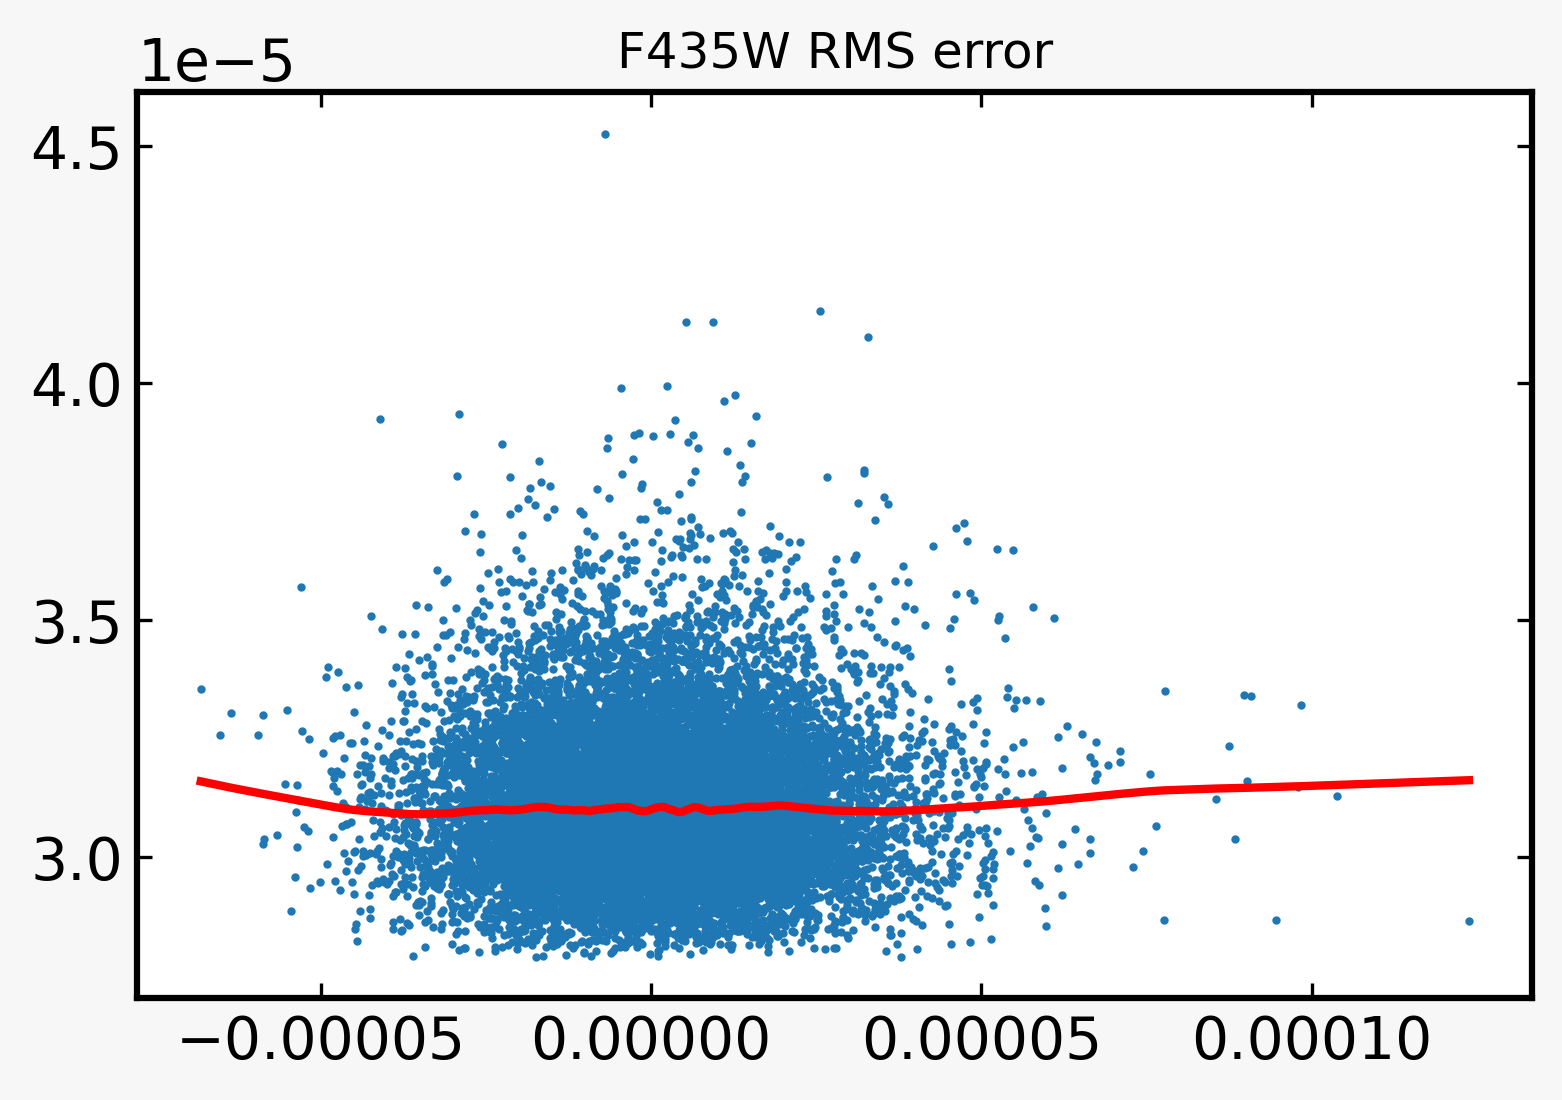

Generating RMS error fits:   5%|▌         | 1/19 [00:02<00:52,  2.90s/it]

0.0010064790702970269 μJy 0.00012379182740671725
-0.0010745750062824723 μJy 0.0010064790702970269 μJy
3.600959457921613e-05 6.130927623022457e-05


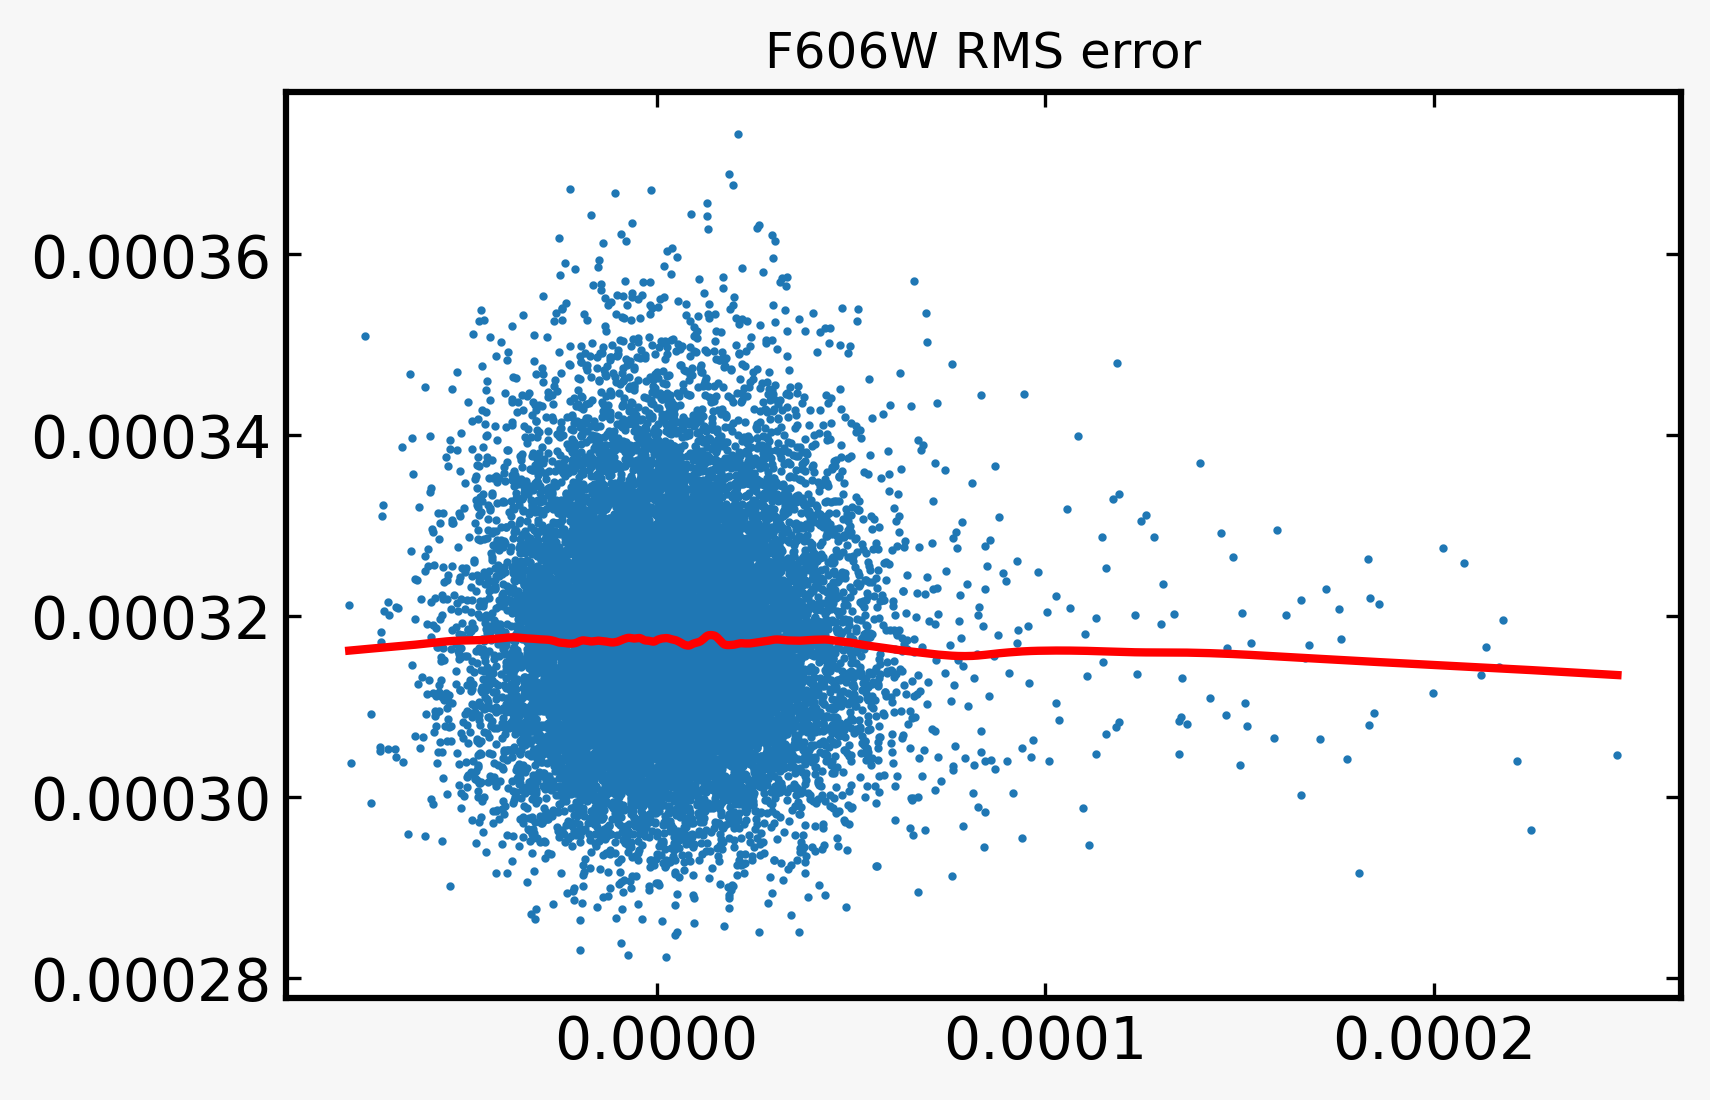

Generating RMS error fits:  11%|█         | 2/19 [00:05<00:49,  2.88s/it]

0.0009939648239060137 μJy 0.0002470939947819086
-0.0008263977925811977 μJy 0.0009939648239060137 μJy
0.0002949877180507102 0.00028532151406747343


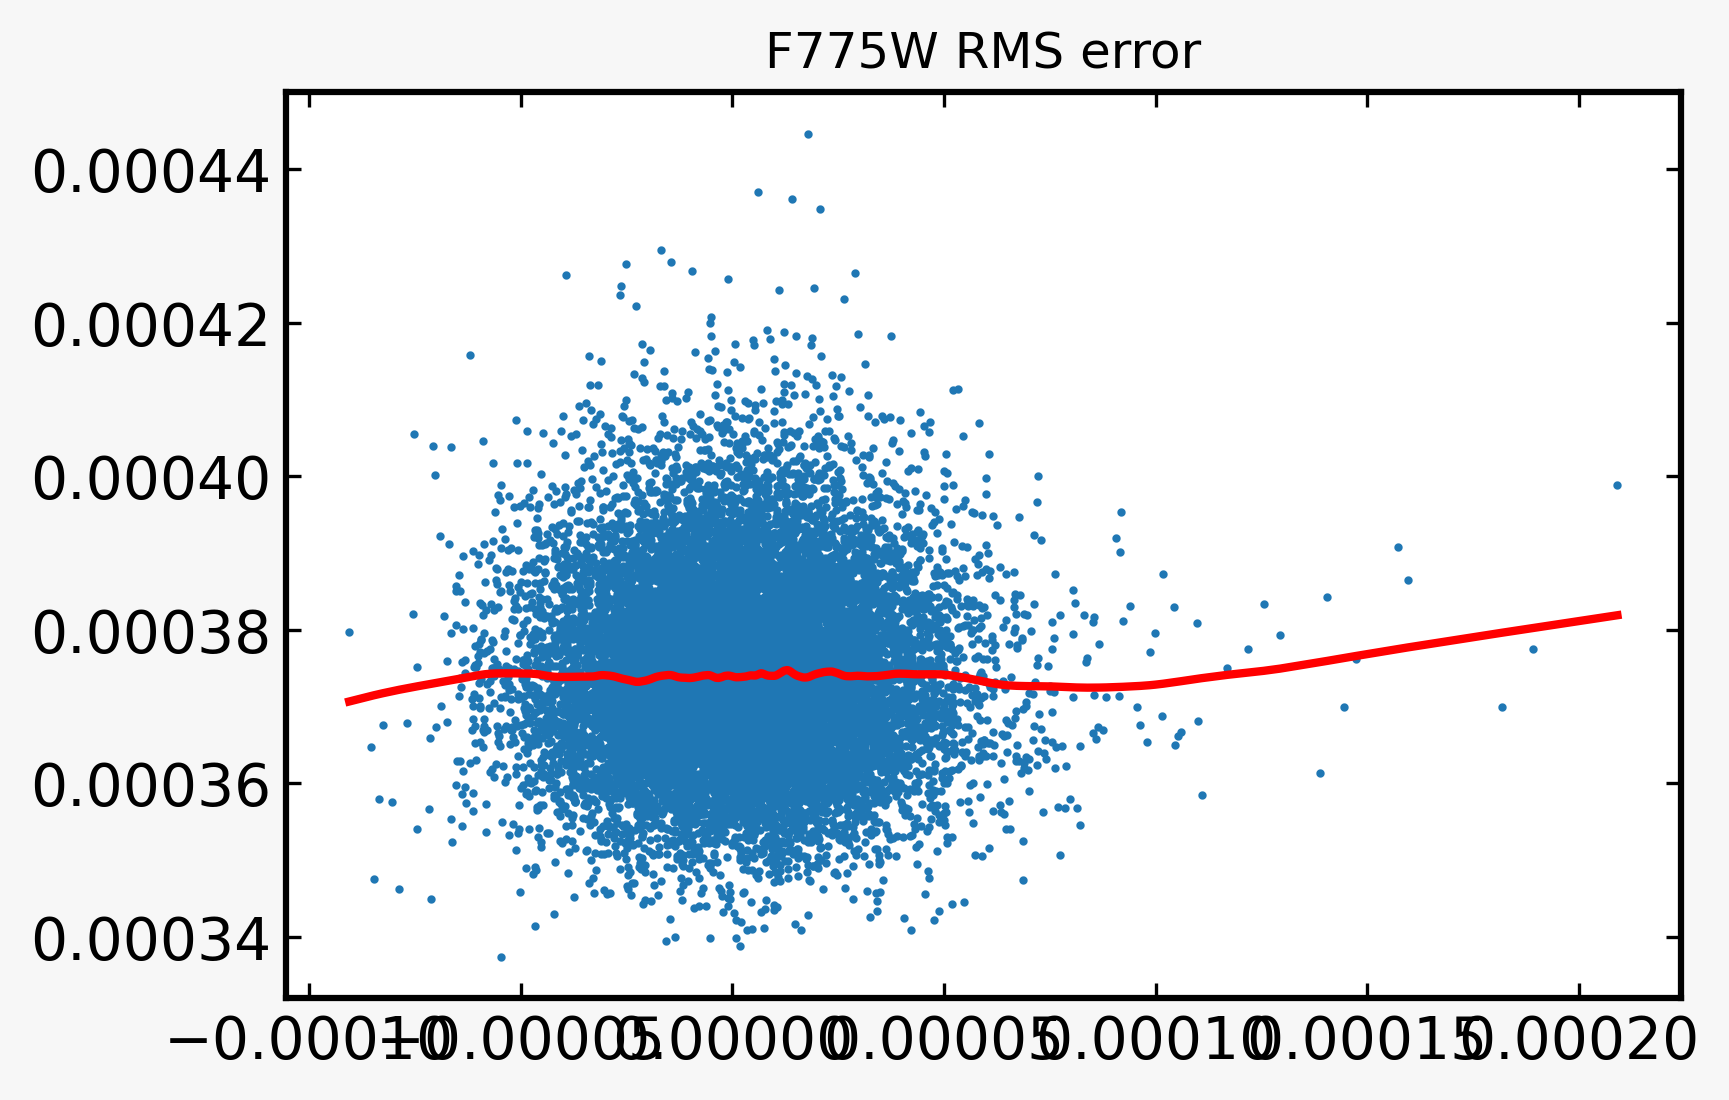

Generating RMS error fits:  16%|█▌        | 3/19 [00:08<00:45,  2.84s/it]

0.00155299999161862 μJy 0.00020910122994907497
-0.0016280386450871027 μJy 0.00155299999161862 μJy
0.0004942517463047356 0.00015589451478640627


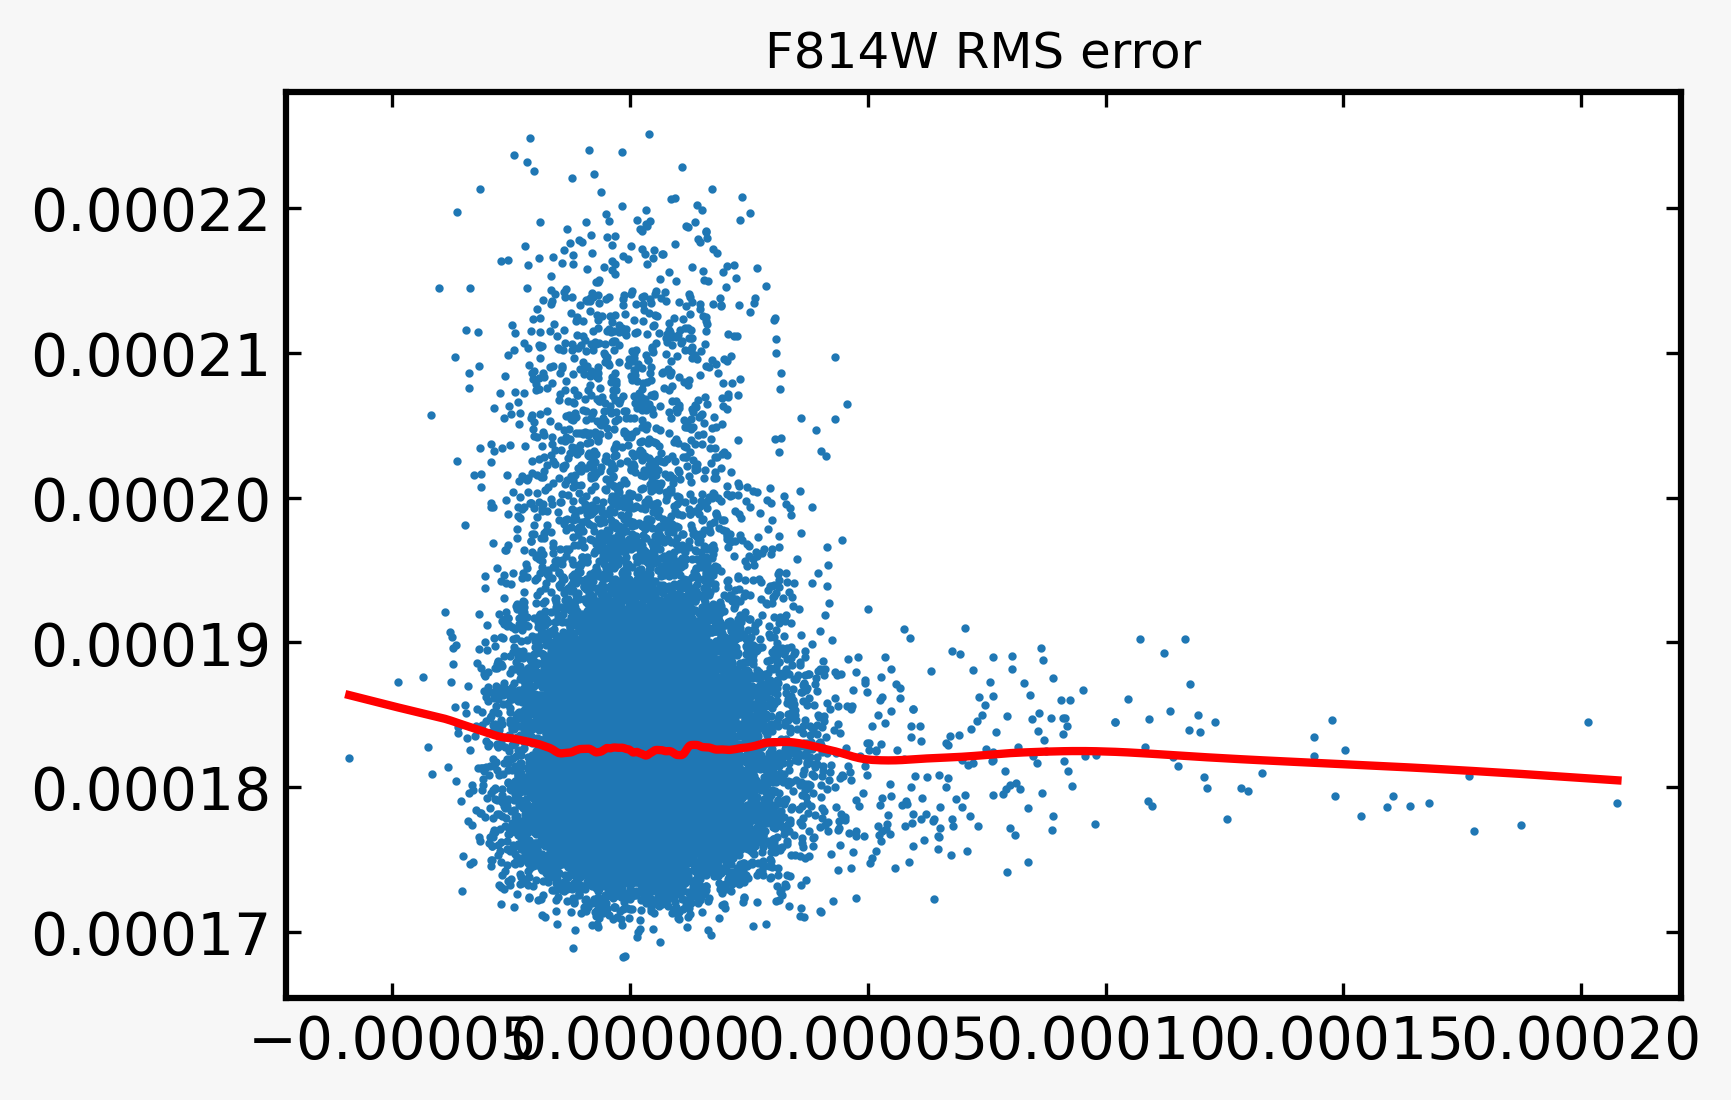

Generating RMS error fits:  21%|██        | 4/19 [00:11<00:41,  2.76s/it]

0.0007460112581331236 μJy 0.0002076223433943999
-0.0007966544669326484 μJy 0.0007460112581331236 μJy
0.00016841991571644985 0.00024754105907819334


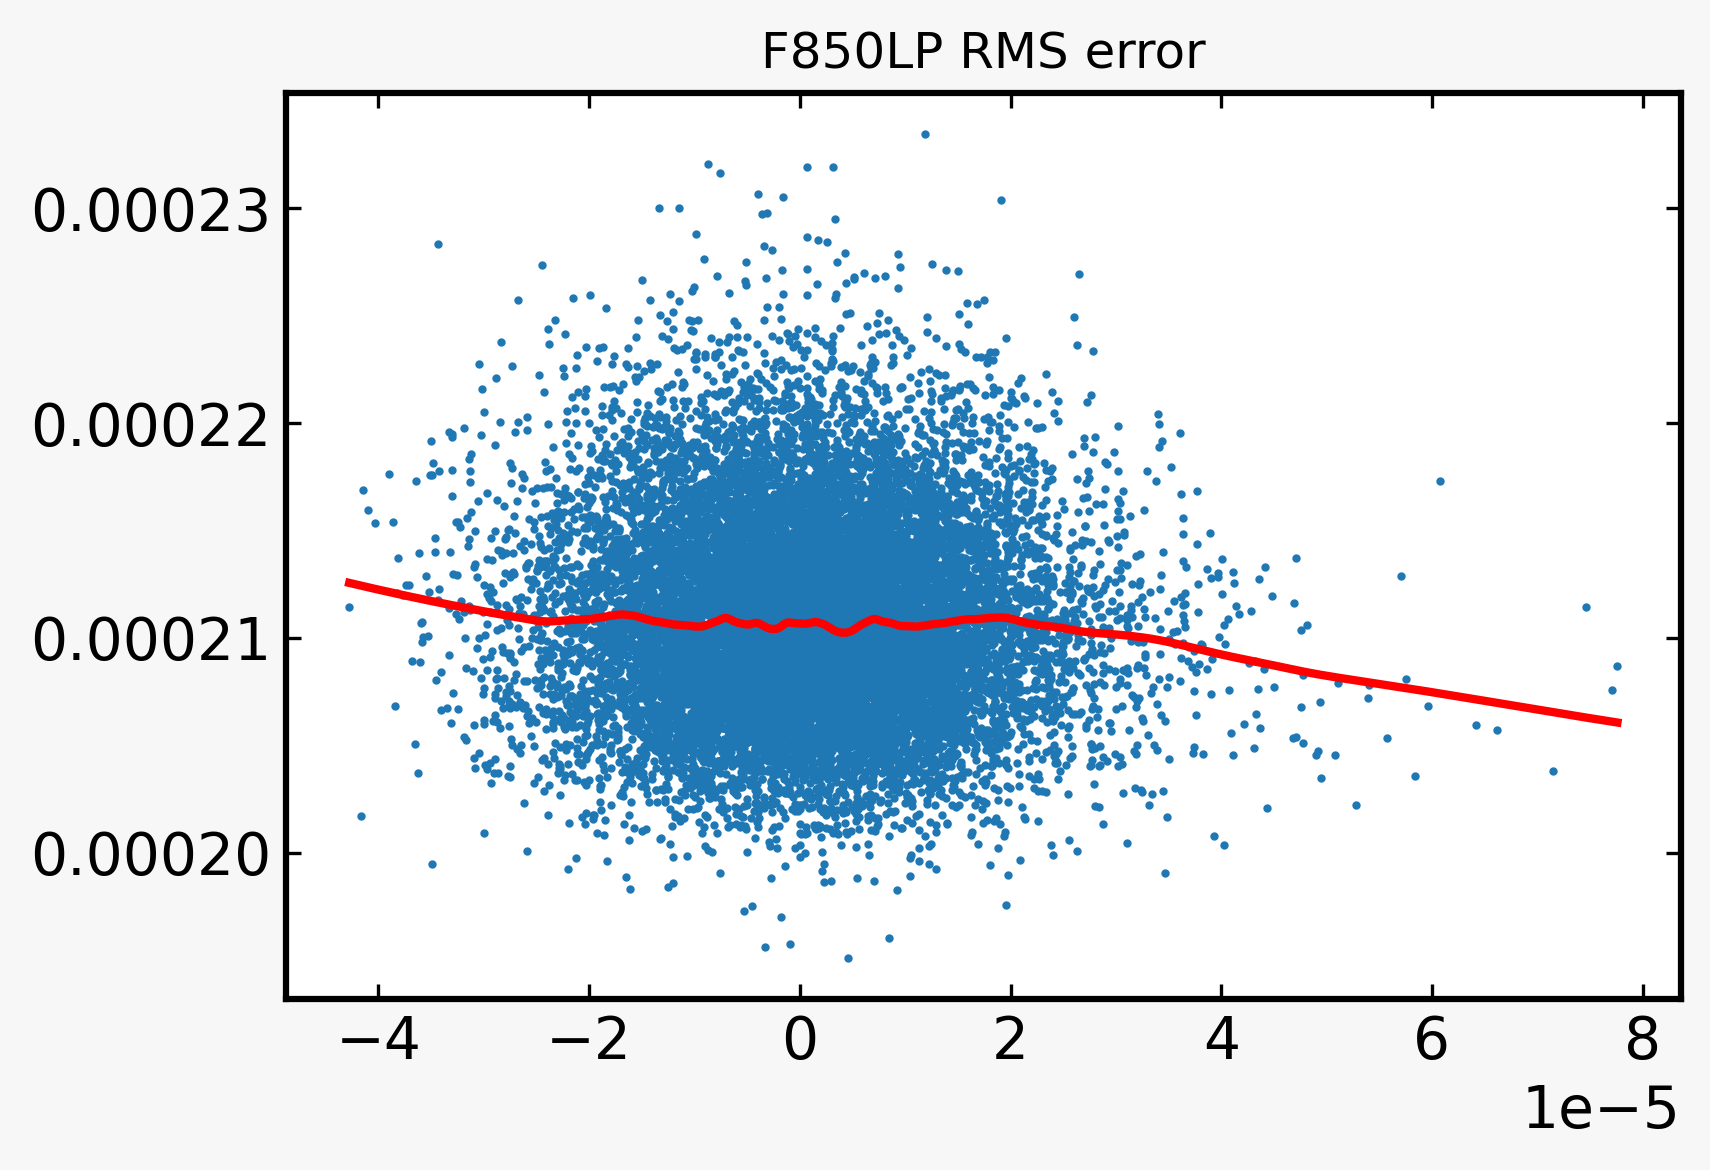

Generating RMS error fits:  26%|██▋       | 5/19 [00:13<00:36,  2.62s/it]

0.0020512690478355394 μJy 7.760665205156632e-05
-0.0017875737216968947 μJy 0.0020512690478355394 μJy
5.4829356749635394e-05 0.00041366029436171864


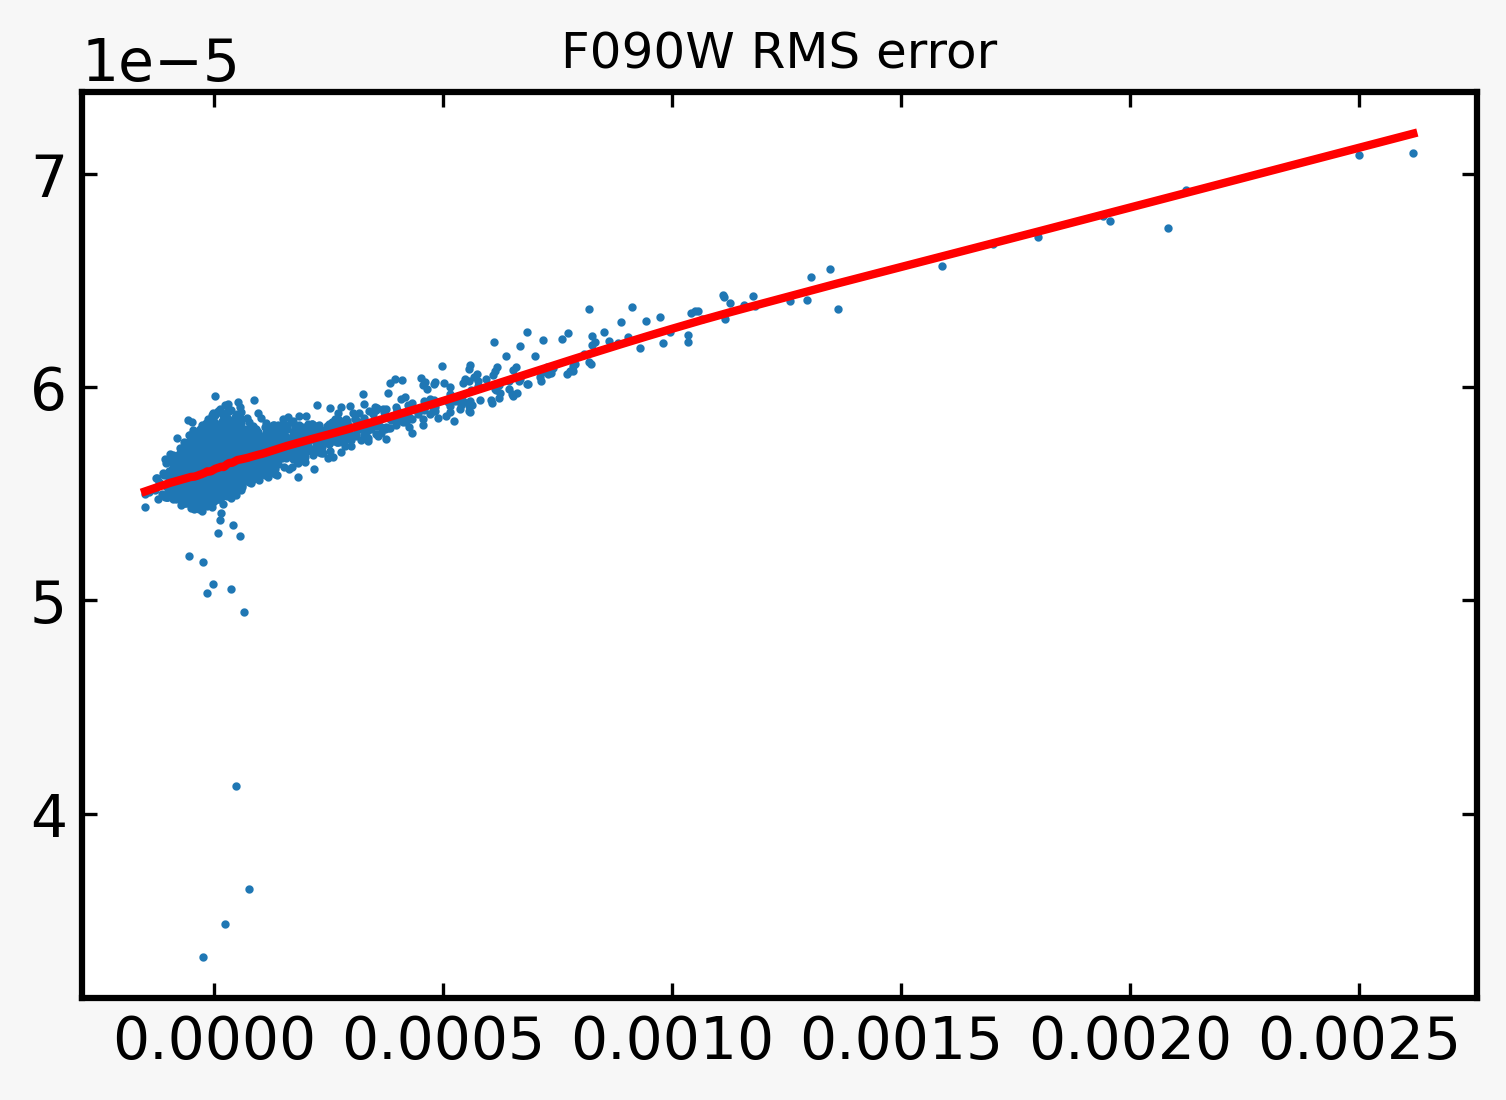

Generating RMS error fits:  32%|███▏      | 6/19 [00:16<00:33,  2.55s/it]

0.0005008619153097281 μJy 0.0026174627918665863
-0.0004196224628821624 μJy 0.0005008619153097281 μJy
5.9352127537909755e-05 5.3059911574524234e-05


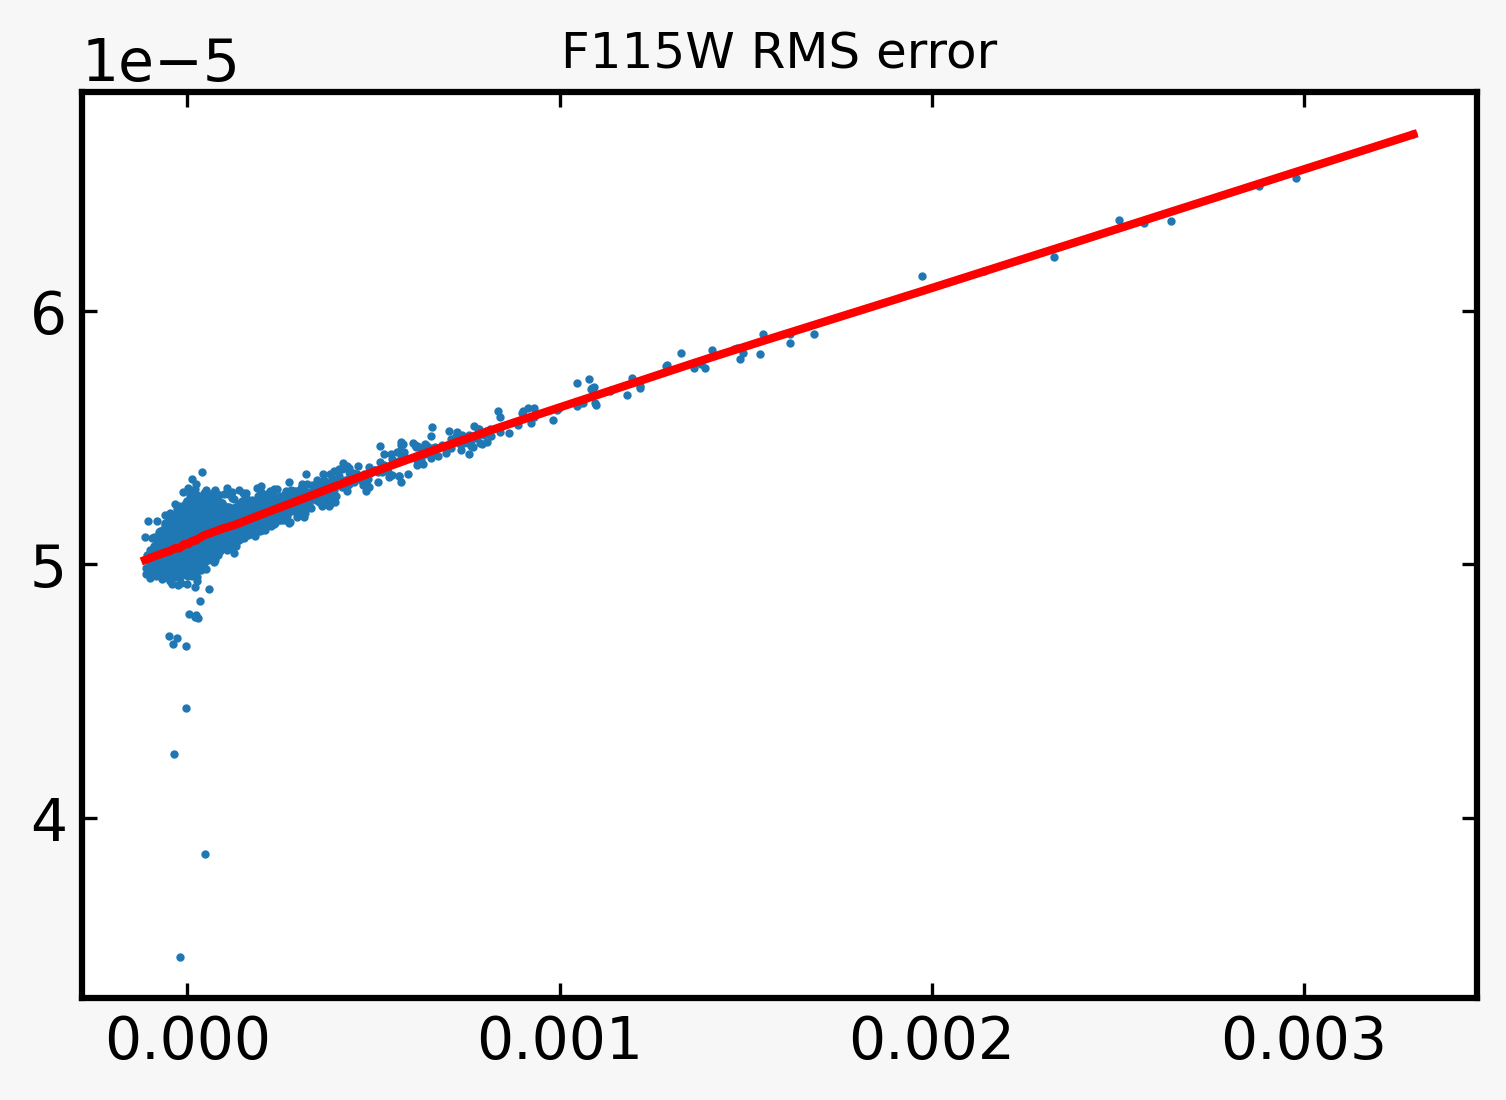

Generating RMS error fits:  37%|███▋      | 7/19 [00:18<00:30,  2.57s/it]

0.0005316204147422722 μJy 0.003293456077250813
-0.0003083660241917156 μJy 0.0005316204147422722 μJy
5.381099784061955e-05 4.900455193417079e-05


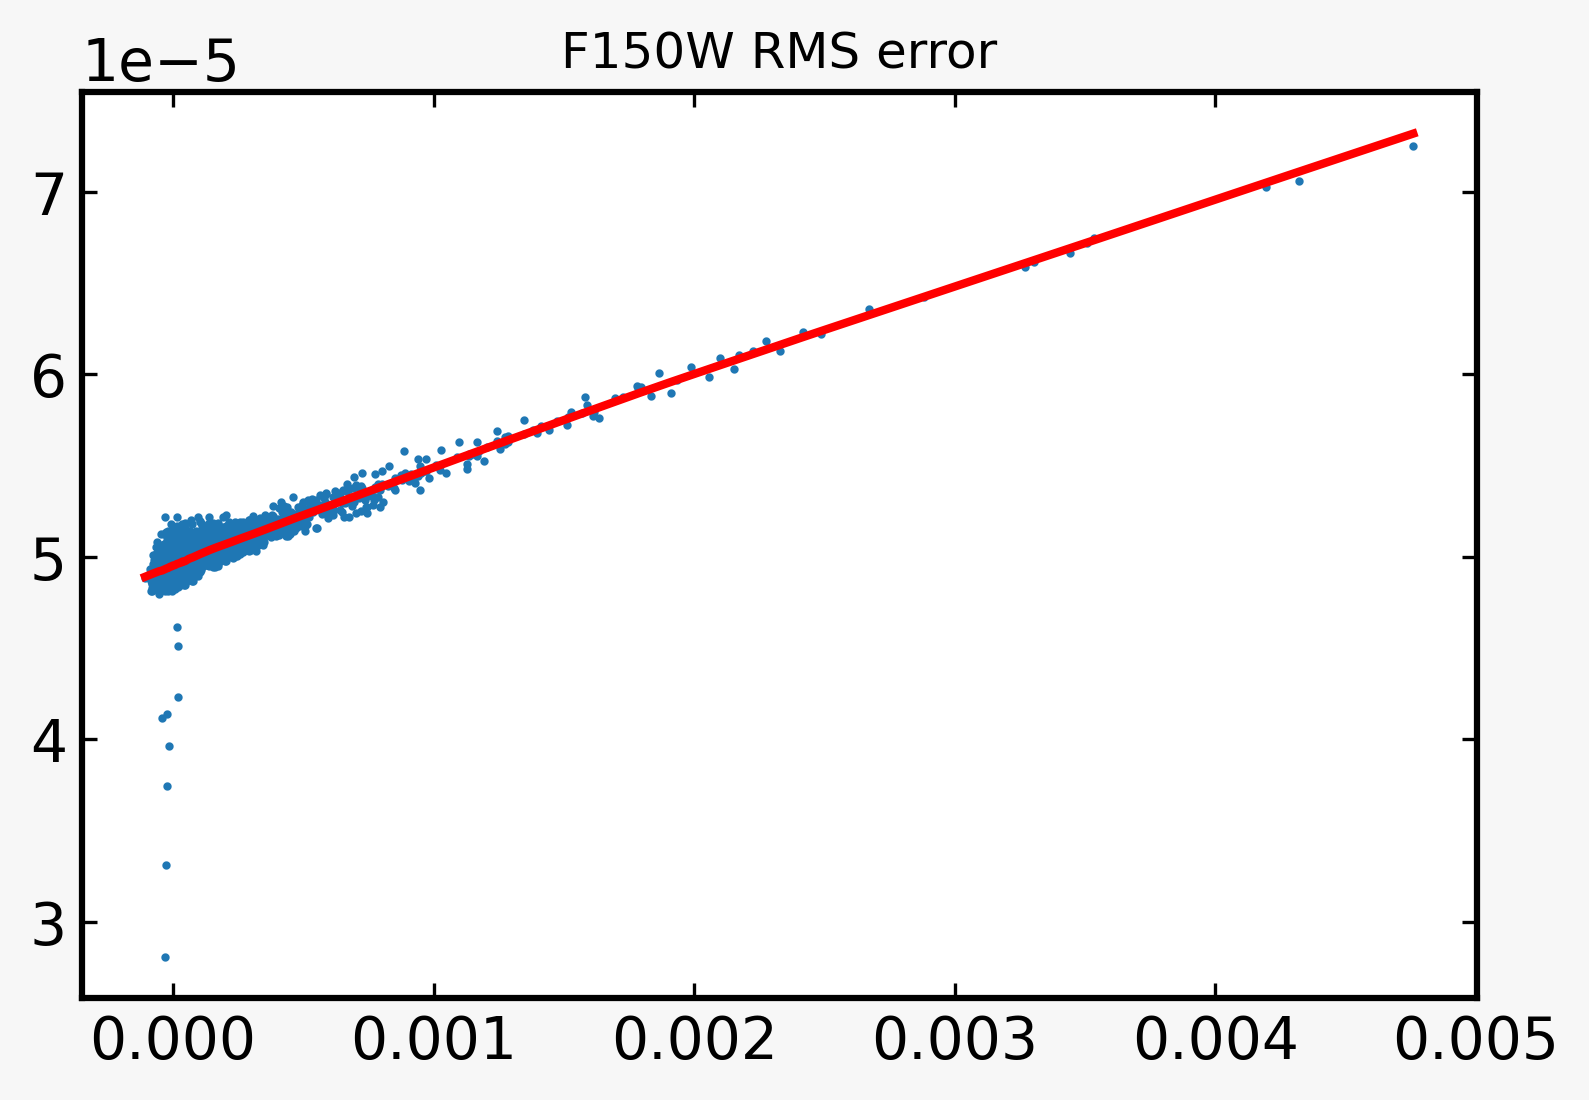

Generating RMS error fits:  42%|████▏     | 8/19 [00:21<00:28,  2.56s/it]

0.0004425232271228233 μJy 0.004759403123804858
-0.00020276723046892307 μJy 0.0004425232271228233 μJy
5.1981639981834355e-05 4.832736599165803e-05


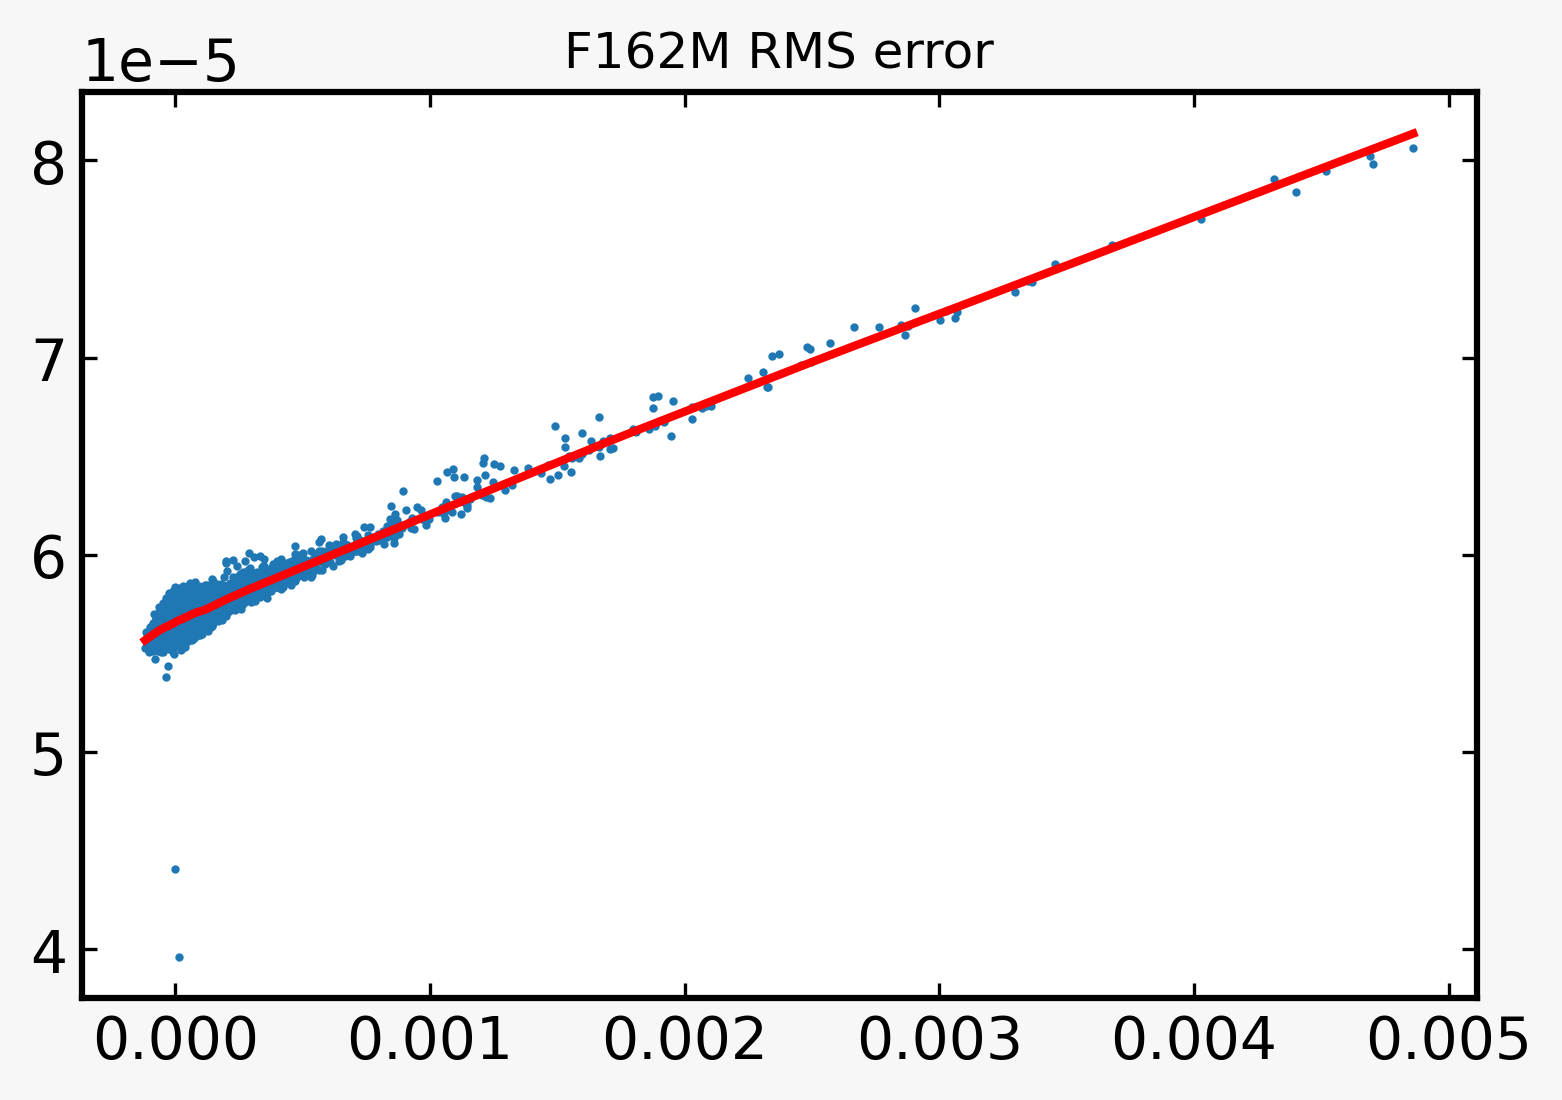

Generating RMS error fits:  47%|████▋     | 9/19 [00:23<00:25,  2.58s/it]

0.00039317126747945264 μJy 0.004861248551328705
-0.00032694603309638983 μJy 0.00039317126747945264 μJy
5.8817668496902416e-05 5.371514389323136e-05


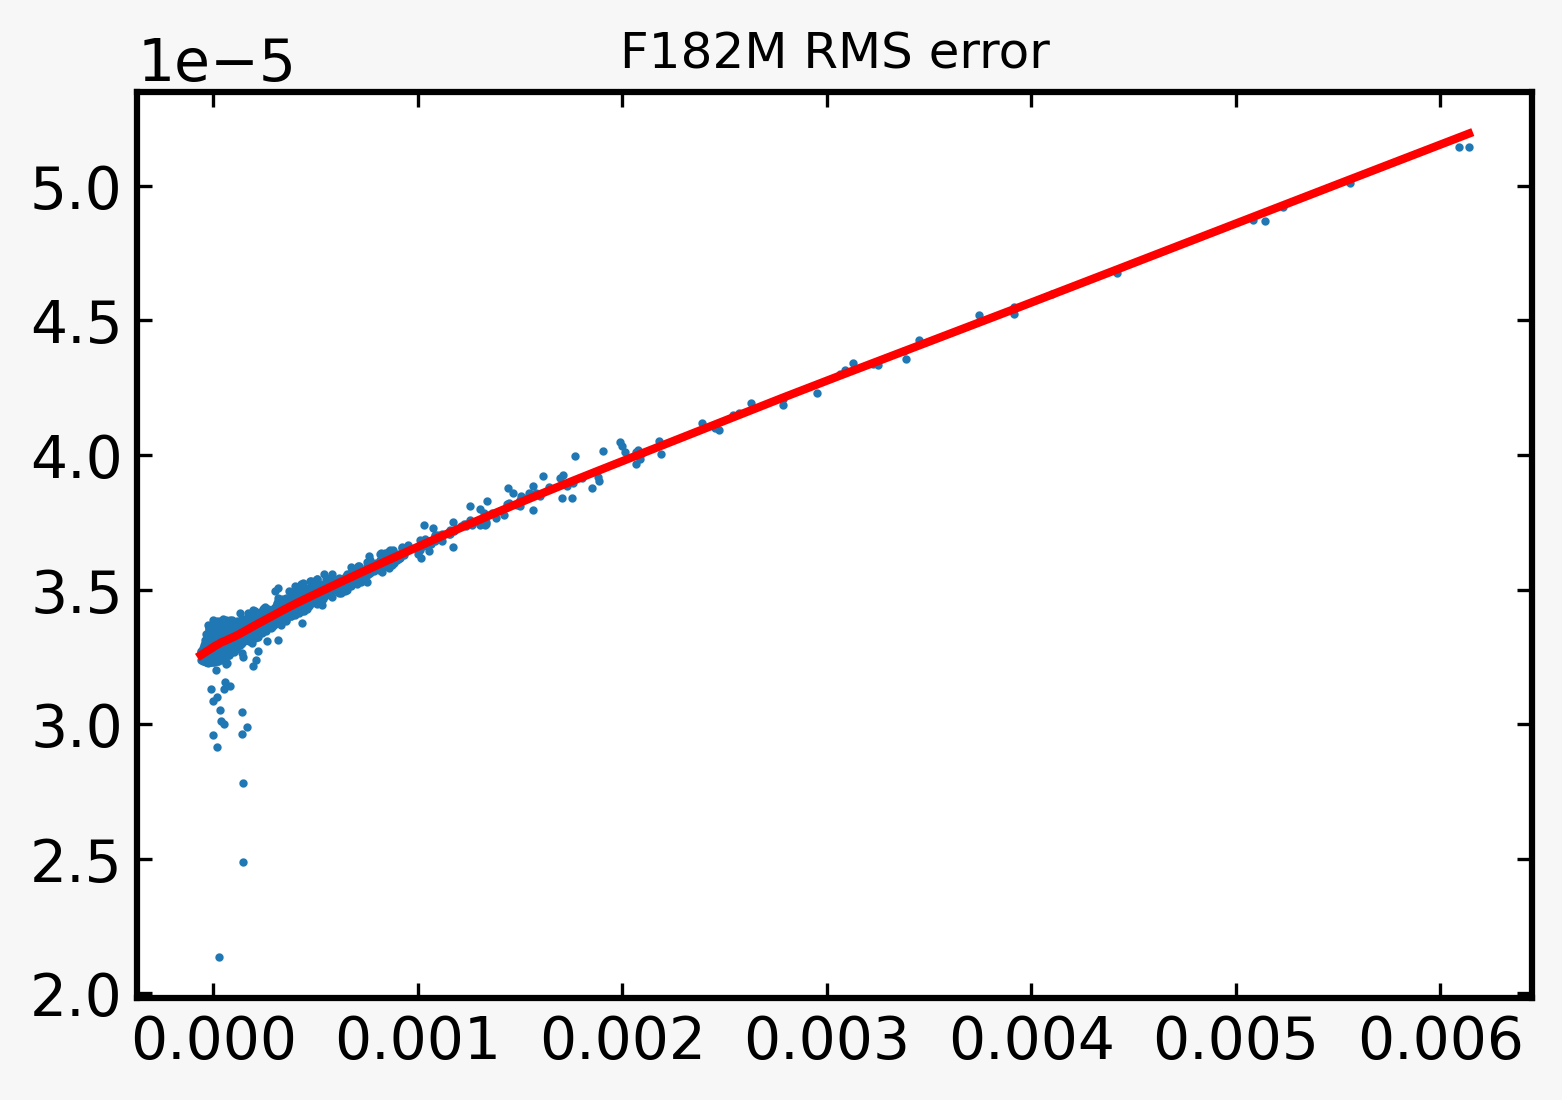

Generating RMS error fits:  53%|█████▎    | 10/19 [00:26<00:23,  2.61s/it]

0.00037946087580690473 μJy 0.006140524753763635
-0.0001819848934342926 μJy 0.00037946087580690473 μJy
3.4389905485283676e-05 3.19957386905106e-05


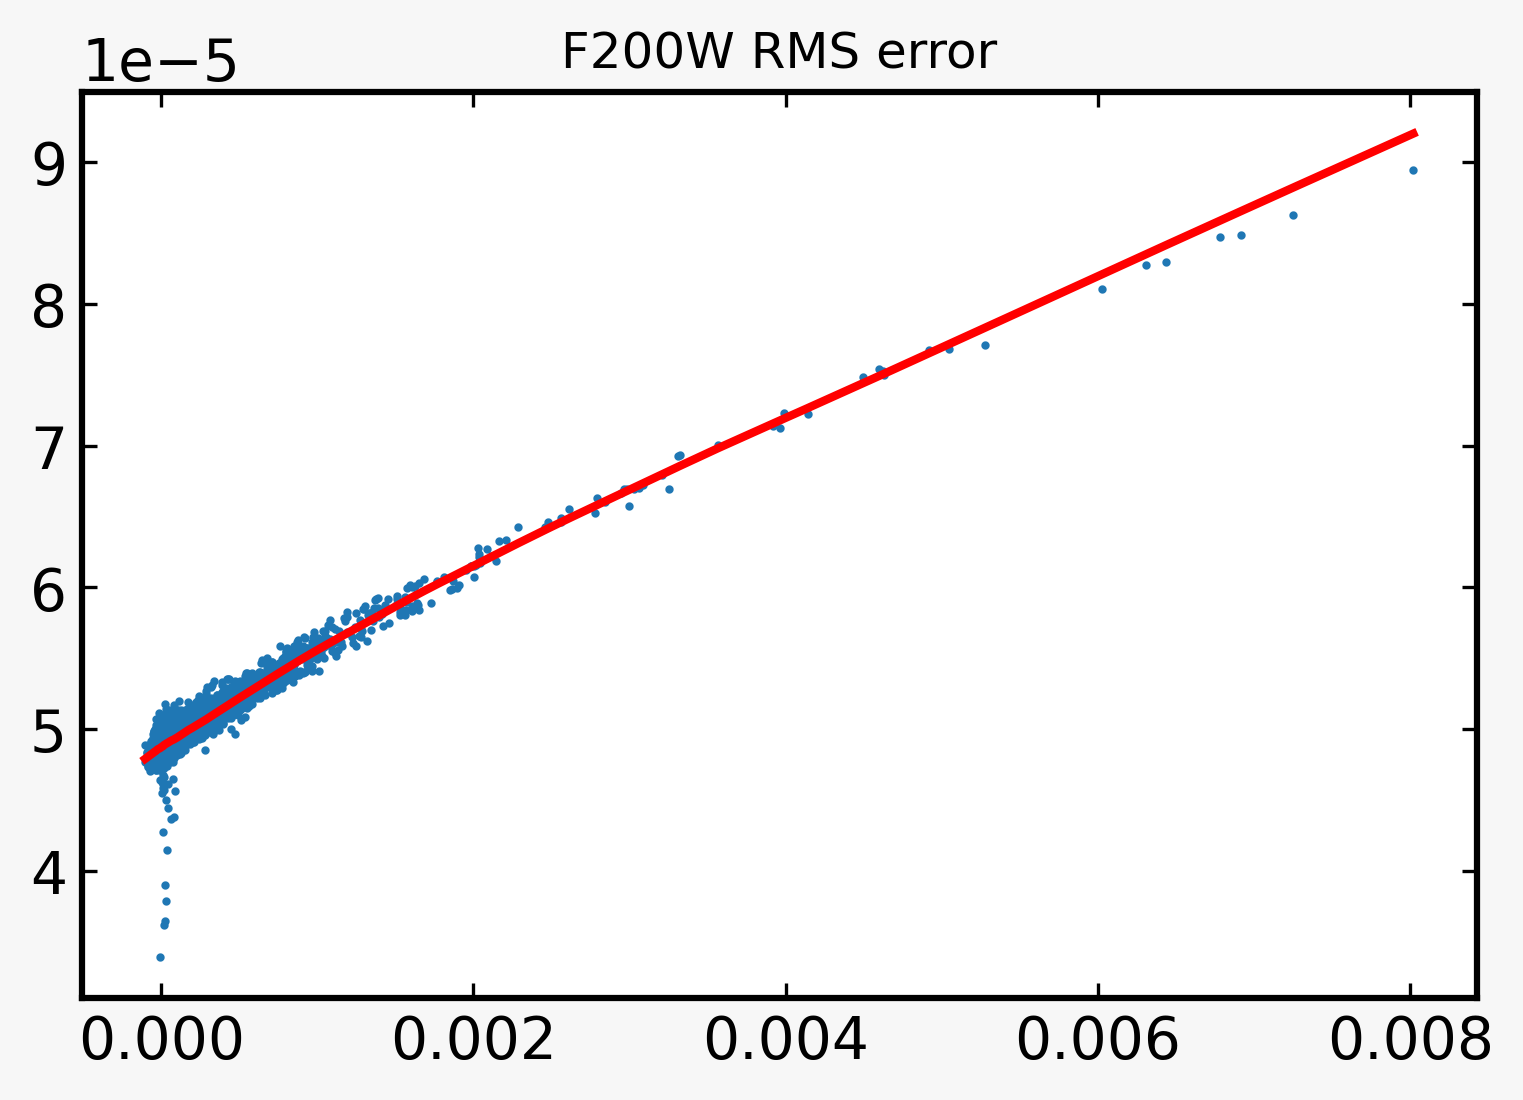

Generating RMS error fits:  58%|█████▊    | 11/19 [00:29<00:20,  2.61s/it]

0.00039312766510522107 μJy 0.008018653034208298
-0.0002367697312697131 μJy 0.00039312766510522107 μJy
5.1447241123879913e-05 4.683915101652627e-05


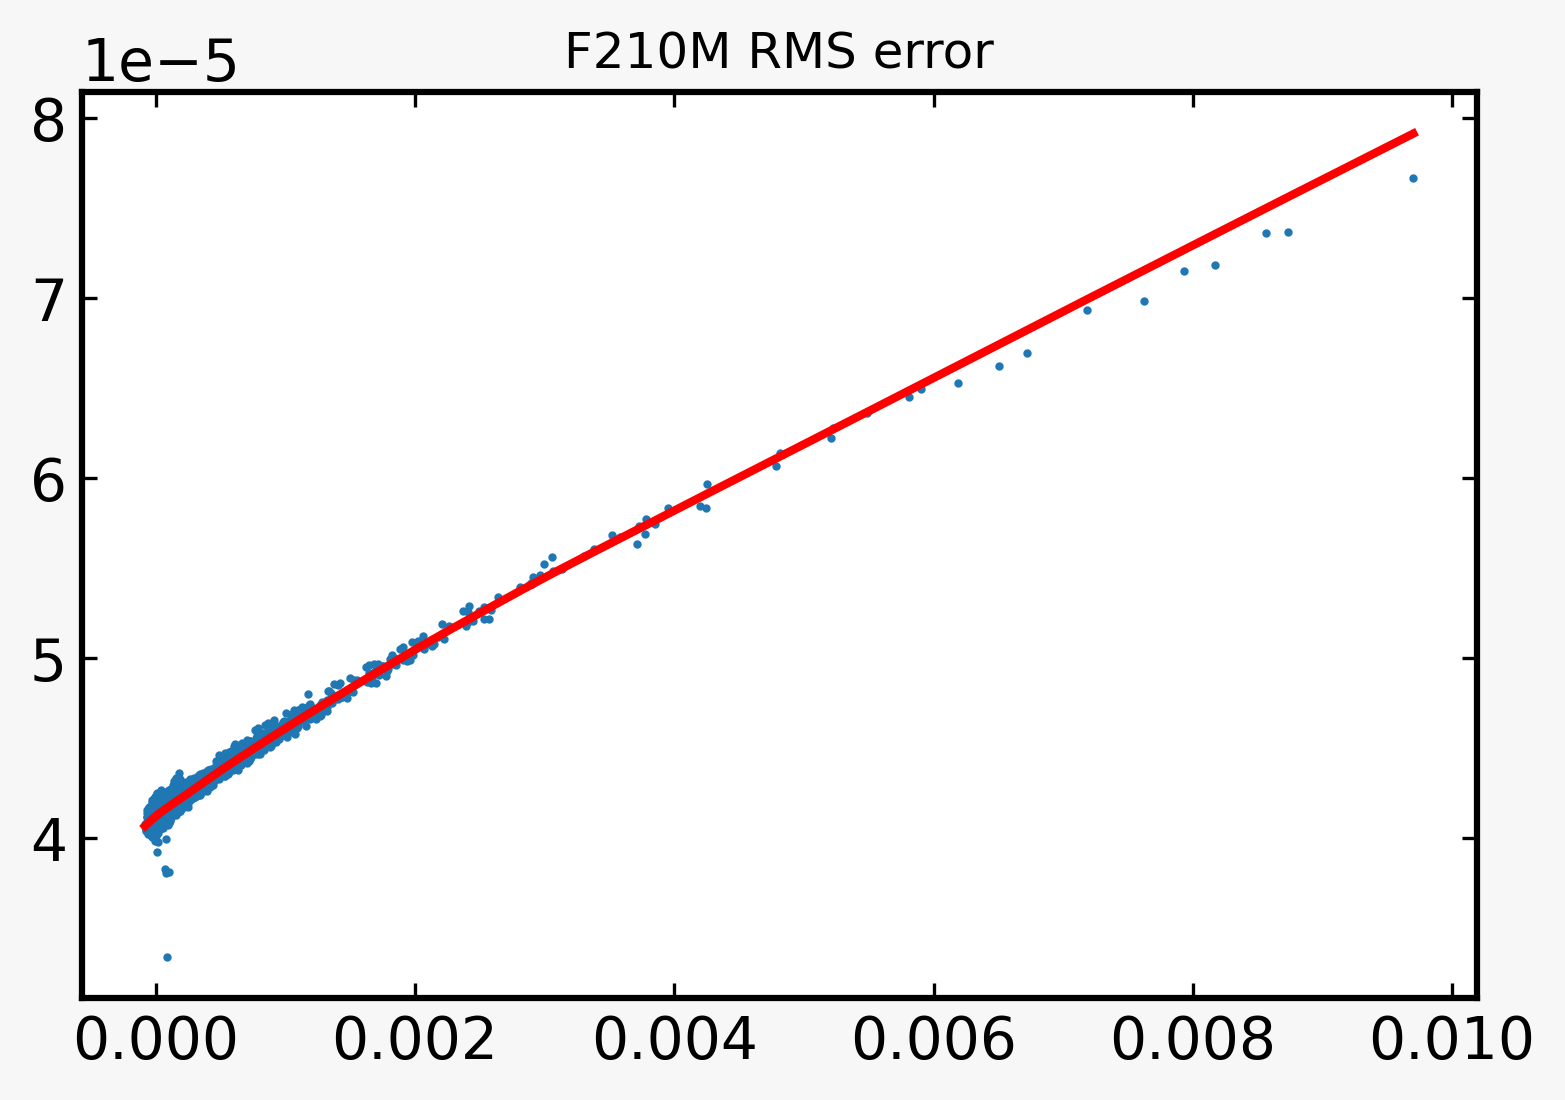

Generating RMS error fits:  63%|██████▎   | 12/19 [00:32<00:18,  2.67s/it]

0.0004066661169262019 μJy 0.009700616921423818
-0.00025631513679990855 μJy 0.0004066661169262019 μJy
4.326069849378783e-05 3.942730188428828e-05


KeyboardInterrupt: 

In [ ]:
redshift_code = '010_z005p000' 
galaxy_index = 0

mock_galaxy = MockResolvedGalaxy.init_mock_from_synthesizer(redshift_code, galaxy_index, grid_dir = grid_dir, file_path = path, mock_survey = 'JOF_psfmatched')

In [ ]:
import synthesizer
synthesizer.__file__

'/nvme/scratch/work/tharvey/synthesizer/synthesizer/src/synthesizer/__init__.py'

In [71]:
import ast
import pickle

In [96]:
str = "{'meta': {'run_name': 'photoz_delayed', 'redshift': 'eazy', 'redshift_sigma': 'eazy', 'min_redshift_sigma': 0.5, 'fit_photometry': 'TOTAL_BIN+MAG_APER_TOTAL', 'sampler': 'multinest'}, 'fit_instructions': {'t_bc': 0.01, 'delayed': {'tau': [0.01, 15], 'massformed': [5.0, 12.0], 'age': [0.001, 15], 'age_prior': 'uniform', 'metallicity_prior': 'uniform', 'metallicity': [0, 3]}, 'nebular': {'logU': [-3.0, -1.0]}, 'dust': {'type': 'Calzetti', 'Av': [0, 5.0]}}}"
dictionary = ast.literal_eval(str)

p = pickle.dumps(dictionary)

dictionary = pickle.loads(p)

print(dictionary)


dust = {}
dust["type"] = "Calzetti"
dust["Av"] = [0, 5.0]

nebular = {}
nebular["logU"] = [-3.0, -1.0]

resolved_sfh = {
'age_max': [0.01, 2.5], # Gyr 
'age_min': [0, 2.5], # Gyr
'metallicity': [1e-3, 2.5], # solar
'massformed': [4, 12], # log mstar/msun
}

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = [0, 5.0]

fit_instructions = {"t_bc":0.01,
                "constant":resolved_sfh,
                "nebular":nebular,
                "dust":dust,  
                }
# This means that we are fixing the photo-z to the results from the 'photoz_DPL' run,
# specifically the 'MAG_APER_TOTAL' photometry
# We are fitting only the resolved photometry in the 'TOTAL_BIN' bins
meta = {'run_name':'CNST_SFH_RESOLVED', 'redshift':'photoz_delayed', 'redshift_id':'MAG_APER_TOTAL',
        'fit_photometry':'bin'}
resolved_dict = {'meta': meta, 'fit_instructions': fit_instructions}
resolved_dicts = [copy.deepcopy(resolved_dict) for i in range(10)]

{'meta': {'run_name': 'photoz_delayed', 'redshift': 'eazy', 'redshift_sigma': 'eazy', 'min_redshift_sigma': 0.5, 'fit_photometry': 'TOTAL_BIN+MAG_APER_TOTAL', 'sampler': 'multinest'}, 'fit_instructions': {'t_bc': 0.01, 'delayed': {'tau': [0.01, 15], 'massformed': [5.0, 12.0], 'age': [0.001, 15], 'age_prior': 'uniform', 'metallicity_prior': 'uniform', 'metallicity': [0, 3]}, 'nebular': {'logU': [-3.0, -1.0]}, 'dust': {'type': 'Calzetti', 'Av': [0, 5.0]}}}


In [101]:
bagpipes_dir = '/nvme/scratch/work/tharvey/bagpipes/'
bagpipes_filter_dir = bagpipes_dir + 'inputs/filters/'


class Test:
    def dummy_function(fit_instructions, filt_dir = bagpipes_filter_dir, fit_photometry = 'all',
        run_dir = f'pipes/', overwrite=False):
        print(fit_instructions)
        print(filt_dir)
        return 

test = [Test() for i in range(10)]

from joblib import Parallel, delayed

Parallel(n_jobs=n_jobs)(delayed(galaxies[i].run_bagpipes)(run_dicts[i]) for i in range(len(galaxies)))
Parallel(n_jobs = 6)(delayed(test[i].dummy_function)(resolved_dicts[i]) for i in range(10))

{'meta': {'run_name': 'CNST_SFH_RESOLVED', 'redshift': 'photoz_delayed', 'redshift_id': 'MAG_APER_TOTAL', 'fit_photometry': 'bin'}, 'fit_instructions': {'t_bc': 0.01, 'constant': {'age_max': [0.01, 2.5], 'age_min': [0, 2.5], 'metallicity': [0.001, 2.5], 'massformed': [4, 12]}, 'nebular': {'logU': [-3.0, -1.0]}, 'dust': {'type': 'Calzetti', 'Av': [0, 5.0]}}}
{'meta': {'run_name': 'CNST_SFH_RESOLVED', 'redshift': 'photoz_delayed', 'redshift_id': 'MAG_APER_TOTAL', 'fit_photometry': 'bin'}, 'fit_instructions': {'t_bc': 0.01, 'constant': {'age_max': [0.01, 2.5], 'age_min': [0, 2.5], 'metallicity': [0.001, 2.5], 'massformed': [4, 12]}, 'nebular': {'logU': [-3.0, -1.0]}, 'dust': {'type': 'Calzetti', 'Av': [0, 5.0]}}}
{'meta': {'run_name': 'CNST_SFH_RESOLVED', 'redshift': 'photoz_delayed', 'redshift_id': 'MAG_APER_TOTAL', 'fit_photometry': 'bin'}, 'fit_instructions': {'t_bc': 0.01, 'constant': {'age_max': [0.01, 2.5], 'age_min': [0, 2.5], 'metallicity': [0.001, 2.5], 'massformed': [4, 12]}, 'n

[None, None, None, None, None, None, None, None, None, None]